In [1]:
import pandas as pd

In [3]:
# organization_path = '../Dataset/bulk_export/organizations.csv' 
organization_path = '../Dataset/bulk_export/organizations.csv' 
organization_data = pd.read_csv(organization_path)

# Step 2: Manipulate or analyze the data as needed
# For example, you can print the first few rows of the DataFrame using .head()
# print("First 5 rows of the DataFrame:")
# print(organization_data.head())

# Or you can perform some basic analysis, such as getting summary statistics using .describe()
# print("\nSummary statistics of the DataFrame:")
# print(organization_data.describe())

organization_data_num_rows = organization_data.shape[0]
print("Number of Organization in the Organization.csv:", organization_data_num_rows)
organization_data_num_columns = organization_data.shape[1] 
print("Number of columns in the Organization.csv:", organization_data_num_columns)
organization_data_column_names = organization_data.columns
print("Column names in the Organization.csv:")
for name in organization_data_column_names:
    print(name)

Number of Organization in the Organization.csv: 2000
Number of columns in the Organization.csv: 44
Column names in the Organization.csv:
uuid_org
name_org
permalink_org
domain
homepage_url
country_code
state_code
region
city
address
postal_code
status
short_description
category_list
category_groups_list
num_funding_rounds
total_funding_usd
total_funding
total_funding_currency_code
founded_on
last_funding_on
closed_on
facebook_url
linkedin_url
twitter_url
age_months
has_facebook_url
has_twitter_url
has_linkedin_url
round_count
raised_amount_usd
last_round_investment_type
last_round_raised_amount_usd
last_round_post_money_valuation
last_round_timelapse_months
investor_countwup
last_round_investor_count
founders_dif_country_count
founders_male_count
founders_female_count
founders_degree_count_total
founders_degree_count_max
founders_degree_count_mean
outcome


# Preprocessing the Data 

## Filtering the companies

1 - I filtered companies using their creation date

In [4]:
from datetime import datetime

# Define the warm up window 
start_date = datetime.strptime('2015-01-01', '%Y-%m-%d') # Start Day: 1 of January of 2015
end_date = datetime.strptime('2018-12-31', '%Y-%m-%d') # End Day: 31 of December of 2018

In [5]:
import csv

with open('2000_filtered_data.csv', 'r') as f, open('organizations_filtered_by_date.csv', 'w', newline='') as f_out:
    reader = csv.reader(f)
    writer = csv.writer(f_out)

    header = next(reader)
    writer.writerow(header)

    date_index = header.index('founded_on')

    # Read the rest of the csv and write rows where the date is within the range
    for row in reader:
        date_str = row[date_index]
        if date_str:  # Check if the date string is not empty
            try:
                date = datetime.strptime(date_str, '%Y-%m-%d')
                if start_date <= date <= end_date:
                    writer.writerow(row)
            except ValueError:
                print("Error: Unable to parse date string '{}'".format(date_str))
        else:
            print("Warning: Empty date string encountered in row {}".format(row))

Looking at the dataset, we see that there is a column that also let us differentiate between an Companies and Investment firms in the domain column

In [6]:
with open('organizations_filtered_by_date.csv', 'r') as f, open('organizations_filtered_by_date_and_roles.csv', 'w', newline='') as f_out:
    reader = csv.reader(f)
    writer = csv.writer(f_out)

    header = next(reader)  # This gets the header row
    writer.writerow(header)  # Write the header to the new file

    # Find the index of the date column (replace 'date_column' with your column's name)
    roles_index = header.index('domain')

    # Read the rest of the csv and write rows where the date is within the range
    for row in reader:
        roles_string = row[roles_index]
        if roles_string:  # Check if the date string is not empty
            try:
                if roles_string == "company":
                    writer.writerow(row)
            except ValueError:
                print("Error: Unable to parse string string '{}'".format(roles_string))
        else:
            print("Warning: Empty string string encountered in row {}".format(row))


Clean the database by dropping the columns that are not relevant for the study

In [7]:
# Specify the columns to drop
columns_to_drop = ['type', 
    'cb_url', 
    'rank', 
    'created_at', 
    'updated_at', 
    'legal_name', 
    'roles', 
    'cb_url', 
    'rank', 
    'created_at', 
    'updated_at', 
    'legal_name', 
    'roles', 
    'email', 
    'phone', 
    'logo_url', 
    'alias1', 
    'alias2', 
    'alias3', 
    'primary_role', 
    'num_exits']

# Drop the specified columns
organizations_data = organization_data.drop(columns=columns_to_drop)
organizations_data.to_csv('../Dataset/filtered_data/filtered_organization.csv', index=False)

KeyError: "['type', 'cb_url', 'rank', 'created_at', 'updated_at', 'legal_name', 'roles', 'cb_url', 'rank', 'created_at', 'updated_at', 'legal_name', 'roles', 'email', 'phone', 'logo_url', 'alias1', 'alias2', 'alias3', 'primary_role', 'num_exits'] not found in axis"

### Now I merge the organizations with their funding data, IPO data, closure data to further filtering by IPO/Acquisition/Closure

In [ ]:
funding_path = '../Dataset/bulk_export/funding_rounds.csv' 

funding_data = pd.read_csv(funding_path)

In [ ]:
organizations_path = '../Dataset/filtered_data/filtered_organization.csv'

organizations_data = pd.read_csv(organizations_path)

In [ ]:
merged_df = organizations_data.merge(funding_data, left_on='uuid', right_on='org_uuid', how="left")

In [ ]:
merged_df.to_csv('../Dataset/filtered_data/filtered_organization_merged.csv', index=False)

In [ ]:
merged_df_path = '../Dataset/filtered_data/filtered_organization_merged.csv' 

merged_df = pd.read_csv(merged_df_path)

First - I removed the ones closed during the Warmup window 

In [ ]:
merged_df['closed_on'] = pd.to_datetime(merged_df['closed_on'])
filtered_close_merged_df = merged_df[(merged_df['closed_on'] < start_date) | (merged_df['closed_on'] > end_date) | (merged_df['closed_on'].isna())]


Now I removed the ones acquired during the Warmup window 

In [7]:
acquisitions_path = '../Dataset/bulk_export/acquisitions.csv'
acquisitions_data = pd.read_csv(acquisitions_path)
acquisitions_data_num_rows = acquisitions_data.shape[0] 
print("Number of acquisitions in the acquisitions.csv:", acquisitions_data_num_rows)
acquisitions_data_num_columns = acquisitions_data.shape[1] 
print("Number of columns in the acquisitions.csv:", acquisitions_data_num_columns)
acquisitions_data_column_names = acquisitions_data.columns
print("Column names in the acquisitions.csv:")
for name in acquisitions_data_column_names:
    print(name)

Number of acquisitions in the acquisitions.csv: 162216
Number of columns in the acquisitions.csv: 27
Column names in the acquisitions.csv:
uuid
name
type
permalink
cb_url
rank
created_at
updated_at
acquiree_uuid
acquiree_name
acquiree_cb_url
acquiree_country_code
acquiree_state_code
acquiree_region
acquiree_city
acquirer_uuid
acquirer_name
acquirer_cb_url
acquirer_country_code
acquirer_state_code
acquirer_region
acquirer_city
acquisition_type
acquired_on
price_usd
price
price_currency_code


In [ ]:
acquired_df =  filtered_close_merged_df.merge(acquisitions_data, left_on='uuid_x', right_on='acquiree_uuid', how="left")

In [ ]:
acquired_df.to_csv('../Dataset/filtered_data/acquired_df.csv', index=False)

In [ ]:
acquired_df['acquired_on'] = pd.to_datetime(acquired_df['acquired_on'])
filtered_close_acquired_df = acquired_df[(acquired_df['acquired_on'] < start_date) | (acquired_df['acquired_on'] > end_date) | (acquired_df['acquired_on'].isna())]


In [ ]:
filtered_close_acquired_df.to_csv('../Dataset/filtered_data/filtered_close_acquired_df.csv', index=False)

Now I removed the ones that IPO during the Warmup window 

In [14]:
ipos_path = '../Dataset/bulk_export/ipos.csv'  # Replace 'your_file.csv' with the actual path to your CSV file
ipos_data = pd.read_csv(ipos_path)
ipos_data_num_rows = ipos_data.shape[0] 
print("Number of ipos in the ipos.csv:", ipos_data_num_rows)
ipos_data_num_columns = ipos_data.shape[1] 
print("Number of columns in the ipos.csv:", ipos_data_num_columns)
ipos_data_column_names = ipos_data.columns
print("Column names in the ipos.csv:")
for name in ipos_data_column_names:
    print(name)

Number of ipos in the ipos.csv: 50368
Number of columns in the ipos.csv: 27
Column names in the ipos.csv:
uuid
name
type
permalink
cb_url
rank
created_at
updated_at
org_uuid
org_name
org_cb_url
country_code
state_code
region
city
stock_exchange_symbol
stock_symbol
went_public_on
share_price_usd
share_price
share_price_currency_code
valuation_price_usd
valuation_price
valuation_price_currency_code
money_raised_usd
money_raised
money_raised_currency_code


In [ ]:
# Rename the columns before merging to ensure they have unique names
filtered_close_acquired_df.rename(columns={'uuid_x': 'uuid_org'}, inplace=True)
filtered_close_acquired_df.rename(columns={'name_x': 'name_org'}, inplace=True)
filtered_close_acquired_df.rename(columns={'permalink_x': 'permalink_org'}, inplace=True)

ipos_data.rename(columns={'org_uuid': 'uuid_ipos'}, inplace=True)


In [ ]:
ipos_df =  filtered_close_acquired_df.merge(ipos_data, left_on='uuid_org', right_on='uuid_ipos', how="left")

In [ ]:
ipos_df.to_csv('../Dataset/filtered_data/ipos_df.csv', index=False)

In [ ]:
ipos_df['went_public_on'] = pd.to_datetime(ipos_df['went_public_on'])
filtered_close_acquired_ipos_df = ipos_df[(ipos_df['went_public_on'] < start_date) | (ipos_df['went_public_on'] > end_date) | (ipos_df['went_public_on'].isna())]


In [ ]:
filtered_close_acquired_ipos_df.to_csv('../Dataset/filtered_data/filtered_close_acquired_ipos_df.csv', index=False)

## I filter the companies which closed a funding round above Series B or above, which is not interesting for Plug and Play investments


In [ ]:
# Define the series that are Series B or above
series_b_or_above = ['series_b', 'series_c', 'series_d', 'series_e', 'series_f', 'series_g']

# Filter the DataFrame to exclude organizations that have a series B or above in their investment_type

organizations_to_remove = filtered_close_acquired_ipos_df[filtered_close_acquired_ipos_df['investment_type'].isin(series_b_or_above)]['org_uuid'].unique()

In [ ]:
filtered_series_df = filtered_close_acquired_ipos_df[~filtered_close_acquired_ipos_df['org_uuid'].isin(organizations_to_remove)]


In [ ]:
filtered_series_df.to_csv('../Dataset/filtered_data/filtered_series_df.csv', index=False)

-------------

In [ ]:
filtered_df_path = '../Dataset/filtered_data/filtered_series_df.csv'

filtered_data = pd.read_csv(filtered_df_path)

In [ ]:
#Some companies are duplicate because they had a few rounds, this is for taking them away
unique_filtered = filtered_data.drop_duplicates(subset=['uuid_org'], keep='first')


In [ ]:
num_rows = unique_filtered.shape[0]

print(f"There is {num_rows} companies.")

Now we need to clean the data set by removing unwanted columns

In [ ]:
column_names = unique_filtered.columns.tolist()

# Join the column names with commas
column_names_str = '\', \''.join(column_names)

# Print the column names
print(column_names_str)

In [ ]:
columns_to_drop = ['uuid_y', 'name_y', 'type_x', 'permalink_y', 'cb_url_x', 'rank_x', 'created_at_x', 'updated_at_x', 'country_code_y', 'state_code_y', 'region_y', 'city_y', 'investment_type', 'announced_on', 'raised_amount_usd', 'raised_amount', 'raised_amount_currency_code', 'post_money_valuation_usd', 'post_money_valuation', 'post_money_valuation_currency_code', 'investor_count', 'org_uuid', 'org_name_x', 'lead_investor_uuids', 'uuid_x', 'name_x', 'type_y', 'permalink_x', 'cb_url_y', 'rank_y', 'created_at_y', 'updated_at_y', 'acquiree_uuid', 'acquiree_name', 'acquiree_cb_url', 'acquiree_country_code', 'acquiree_state_code', 'acquiree_region', 'acquiree_city', 'acquirer_uuid', 'acquirer_name', 'acquirer_cb_url', 'acquirer_country_code', 'acquirer_state_code', 'acquirer_region', 'acquirer_city', 'acquisition_type', 'acquired_on', 'price_usd', 'price', 'price_currency_code', 'uuid_y.1', 'name_y.1', 'type', 'permalink_y.1', 'cb_url', 'rank', 'created_at', 'updated_at', 'uuid_ipos', 'org_name_y', 'org_cb_url', 'country_code', 'state_code', 'region', 'city', 'stock_exchange_symbol', 'stock_symbol', 'went_public_on', 'share_price_usd', 'share_price', 'share_price_currency_code', 'valuation_price_usd', 'valuation_price', 'valuation_price_currency_code', 'money_raised_usd', 'money_raised', 'money_raised_currency_code']


In [ ]:
unique_filtered = unique_filtered.drop(columns=columns_to_drop)

In [ ]:
column_names = unique_filtered.columns.tolist()

# Join the column names with commas
column_names_str = '\', \''.join(column_names)

# Print the column names
print(column_names_str)

uuid_org', 'name_org', 'permalink_org', 'domain', 'homepage_url', 'country_code_x', 'state_code_x', 'region_x', 'city_x', 'address', 'postal_code', 'status', 'short_description', 'category_list', 'category_groups_list', 'num_funding_rounds', 'total_funding_usd', 'total_funding', 'total_funding_currency_code', 'founded_on', 'last_funding_on', 'closed_on', 'employee_count', 'facebook_url', 'linkedin_url', 'twitter_url


# Now we need to add the predictor variables 

And also delete some attributes that I do not consider relevant

In [ ]:
unique_filtered.rename(columns={'country_code_x': 'country_code'}, inplace=True)
unique_filtered.rename(columns={'state_code_x': 'state_code'}, inplace=True)
unique_filtered.rename(columns={'region_x': 'region'}, inplace=True)
unique_filtered.rename(columns={'city_x': 'city'}, inplace=True)

In [ ]:
unique_filtered.to_csv('../Dataset/filtered_data/unique_filtered.csv', index=False)

In [ ]:
unique_filtered = unique_filtered.drop(columns='employee_count')

Nota para alde: creo que deberia quitar las compañias que tengan al menos 1 funding round pero no diga la cantidad... No lo se


## Company Information

we included the company age in months (age_months) at the beginning of the simulation (ts) and we added variables that measure the presence of the company in social media networks. 

These binary variables indicate whether the company registered in Crunchbase its con- tact information (has_email and has_phone) or a Facebook (has_facebook_url), Twitter (has_twitter_url) or Linkedin (has_linkedin_url) account.

In [3]:
#Beginning of the simulation period

from datetime import datetime

# Define the warm up window 
simulation_start_date = datetime.strptime('2019-01-01', '%Y-%m-%d') # Start Day: 1 of January of 2019
simulation_end_date = datetime.strptime('2022-12-31', '%Y-%m-%d') # End Day: 31 of December of 2022

In [4]:
import math

unique_filtered['founded_on'] = pd.to_datetime(unique_filtered['founded_on'])

unique_filtered['age_months'] = ((simulation_start_date - unique_filtered['founded_on']).dt.days / 30).apply(math.ceil)


NameError: name 'unique_filtered' is not defined

In [ ]:
# Define a function to check if the URL is present
def has_url(url):
    return 1 if pd.notnull(url) else 0

# Convert URLs into binary variables
unique_filtered['has_facebook_url'] = unique_filtered['facebook_url'].apply(has_url)
unique_filtered['has_twitter_url'] = unique_filtered['twitter_url'].apply(has_url)
unique_filtered['has_linkedin_url'] = unique_filtered['linkedin_url'].apply(has_url)

In [ ]:
unique_filtered.to_csv('../Dataset/filtered_data/unique_filtered.csv', index=False)

## Funding information

The variables in this category summarize the funding events occurred in a company during the Warmup window. The availability of a temporal series of funding round events in Crunchbase allowed us to synthesize information about:

- Number of funding rounds that the company achieved before ts (round_count) and the total amount raised in those rounds(raised_amount_usd).

In [16]:
funding_rounds_path = '../Dataset/bulk_export/funding_rounds.csv' 
funding_rounds_data = pd.read_csv(funding_rounds_path)

# Step 2: Manipulate or analyze the data as needed
# For example, you can print the first few rows of the DataFrame using .head()
# print("First 5 rows of the DataFrame:")
# print(funding_rounds_data.head())

# Or you can perform some basic analysis, such as getting summary statistics using .describe()
# print("\nSummary statistics of the DataFrame:")
# print(funding_rounds_data.describe())

funding_rounds_data_num_rows = funding_rounds_data.shape[0]
print("Number of funding_rounds in the funding_rounds.csv:", funding_rounds_data_num_rows)
funding_rounds_data_num_columns = funding_rounds_data.shape[1] 
print("Number of columns in the funding_rounds.csv:", funding_rounds_data_num_columns)
funding_rounds_data_column_names = funding_rounds_data.columns
print("Column names in the funding_rounds.csv:")
for name in funding_rounds_data_column_names:
    print(name)

Number of funding_rounds in the funding_rounds.csv: 631092
Number of columns in the funding_rounds.csv: 24
Column names in the funding_rounds.csv:
uuid
name
type
permalink
cb_url
rank
created_at
updated_at
country_code
state_code
region
city
investment_type
announced_on
raised_amount_usd
raised_amount
raised_amount_currency_code
post_money_valuation_usd
post_money_valuation
post_money_valuation_currency_code
investor_count
org_uuid
org_name
lead_investor_uuids


In [13]:
unique_filtered = pd.read_csv('../Dataset/filtered_data/unique_filtered.csv')
unique_filtered_column_names = unique_filtered.columns
print("Column names in the unique_filtered.csv:")
for name in unique_filtered_column_names:
    print(name)


Column names in the unique_filtered.csv:
uuid_org
name_org
permalink_org
domain
homepage_url
country_code
state_code
region
city
address
postal_code
status
short_description
category_list
category_groups_list
num_funding_rounds
total_funding_usd
total_funding
total_funding_currency_code
founded_on
last_funding_on
closed_on
facebook_url
linkedin_url
twitter_url
age_months
has_facebook_url
has_twitter_url
has_linkedin_url


In [14]:
# Convert relevant date columns to datetime format
unique_filtered['founded_on'] = pd.to_datetime(unique_filtered['founded_on'])
unique_filtered['last_funding_on'] = pd.to_datetime(unique_filtered['last_funding_on'])

funding_rounds = funding_rounds_data[funding_rounds_data['org_uuid'].isin(unique_filtered['uuid_org'])]

funding_rounds['announced_on'] = pd.to_datetime(funding_rounds['announced_on'])

# Set the simulation start date (ts) to January 1, 2019
ts = pd.to_datetime('2019-01-01')

# 3. Filter the funding rounds that occurred before ts
funding_before_ts = funding_rounds[funding_rounds['announced_on'] < ts]

# 4. Count the number of funding rounds for each company
round_count = funding_before_ts.groupby('org_uuid').size().reset_index(name='round_count')

# 5. Sum up the raised amount in those rounds for each company
raised_amount_usd = funding_before_ts.groupby('org_uuid')['raised_amount_usd'].sum().reset_index(name='raised_amount_usd')

# Merge round count and raised amount into unique_filtered DataFrame
unique_filtered = unique_filtered.merge(round_count, left_on="uuid_org", right_on='org_uuid', how='left', suffixes=('', '_x'))
unique_filtered = unique_filtered.merge(raised_amount_usd, left_on="uuid_org", right_on='org_uuid', how='left', suffixes=('', '_y'))

# Replace NaN values with 0 for companies with no data
unique_filtered['round_count'].fillna(0, inplace=True)
unique_filtered['raised_amount_usd'].fillna(0, inplace=True)

# Save the result to a new CSV file
unique_filtered.to_csv('unique_filtered_with_funding_info.csv', index=False)

/var/folders/2r/b60vp1dj2zn0rg5yg_gyy0zr0000gq/T/ipykernel_7300/852572325.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funding_rounds['announced_on'] = pd.to_datetime(funding_rounds['announced_on'])
/var/folders/2r/b60vp1dj2zn0rg5yg_gyy0zr0000gq/T/ipykernel_7300/852572325.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the o

In [31]:
unique_filtered_column_names = unique_filtered.columns
print("Column names in the unique_filtered.csv:")
for name in unique_filtered_column_names:
    print(name)

Column names in the unique_filtered.csv:
uuid_org
name_org
permalink_org
domain
homepage_url
country_code
state_code
region
city
address
postal_code
status
short_description
category_list
category_groups_list
num_funding_rounds
total_funding_usd
total_funding
total_funding_currency_code
founded_on
last_funding_on
closed_on
facebook_url
linkedin_url
twitter_url
age_months
has_facebook_url
has_twitter_url
has_linkedin_url
round_count
raised_amount_usd
last_round_investment_type
last_round_raised_amount_usd
last_round_post_money_valuation
last_round_timelapse_months


In [25]:
unique_filtered = pd.read_csv('unique_filtered_with_funding_info.csv')


In [27]:
unique_filtered = unique_filtered.drop(columns=['org_uuid', 'org_uuid_y'])

- Data about the last funding round in Warmup window: 

• funding round type (last_round_investment_type)

• amount raised(last_round_raised_amount_usd)

• company valuation after this funding round(last_round_post_money_valuation

• time lapsed, in months, between the beginning of the simulation (ts) and when this funding round occurred(last_round_timelapse_months)

In [29]:
import math

# 2. Find the last funding round for each company within the Warmup window
last_round_warmup = funding_before_ts.groupby('org_uuid').last()

# 3. Extract the required data from the last funding round for each company
last_round_investment_type = last_round_warmup['investment_type'].rename('last_round_investment_type')
last_round_raised_amount_usd = last_round_warmup['raised_amount_usd'].rename('last_round_raised_amount_usd')
last_round_post_money_valuation = last_round_warmup['post_money_valuation_usd'].rename('last_round_post_money_valuation')
# 4. Calculate the time lapse in months between simulation start date and the last funding round
last_round_timelapse_months = ((simulation_start_date - last_round_warmup['announced_on']).dt.days / 30).apply(math.ceil).astype(int).rename('last_round_timelapse_months')

In [30]:
# Add extracted data to merged_unique_funding_df DataFrame
#unique_filtered['last_round_investment_type'] = last_round_investment_type
#unique_filtered['last_round_raised_amount_usd'] = last_round_raised_amount_usd
#unique_filtered['last_round_post_money_valuation'] = last_round_post_money_valuation
#unique_filtered['last_round_timelapse_months'] = last_round_timelapse_months

unique_filtered = unique_filtered.merge(last_round_investment_type, left_on="uuid_org", right_on='org_uuid', how='left')
unique_filtered = unique_filtered.merge(last_round_raised_amount_usd, left_on="uuid_org", right_on='org_uuid', how='left')
unique_filtered = unique_filtered.merge(last_round_post_money_valuation, left_on="uuid_org", right_on='org_uuid', how='left')
unique_filtered = unique_filtered.merge(last_round_timelapse_months, left_on="uuid_org", right_on='org_uuid', how='left')



In [32]:
unique_filtered.to_csv('unique_filtered_with_funding_info.csv', index=False)

- Number of (unique) investors who participated in the funding rounds during the Warmup window (investor_count) and specifically, in the last funding (last_round_investor_count).

In [33]:
investments_path = '../Dataset/bulk_export/investments.csv' 
investments_data = pd.read_csv(investments_path)

# Step 2: Manipulate or analyze the data as needed
# For example, you can print the first few rows of the DataFrame using .head()
# print("First 5 rows of the DataFrame:")
# print(investments_data.head())

# Or you can perform some basic analysis, such as getting summary statistics using .describe()
# print("\nSummary statistics of the DataFrame:")
# print(investments_data.describe())

investments_data_num_rows = investments_data.shape[0]
print("Number of investments in the investments.csv:", investments_data_num_rows)
investments_data_num_columns = investments_data.shape[1] 
print("Number of columns in the investments.csv:", investments_data_num_columns)
investments_data_column_names = investments_data.columns
print("Column names in the investments.csv:")
for name in investments_data_column_names:
    print(name)

Number of investments in the investments.csv: 1027342
Number of columns in the investments.csv: 14
Column names in the investments.csv:
uuid
name
type
permalink
cb_url
rank
created_at
updated_at
funding_round_uuid
funding_round_name
investor_uuid
investor_name
investor_type
is_lead_investor


In [34]:
investors_path = '../Dataset/bulk_export/investors.csv' 
investors_data = pd.read_csv(investors_path)

# Step 2: Manipulate or analyze the data as needed
# For example, you can print the first few rows of the DataFrame using .head()
# print("First 5 rows of the DataFrame:")
# print(investors_data.head())

# Or you can perform some basic analysis, such as getting summary statistics using .describe()
# print("\nSummary statistics of the DataFrame:")
# print(investors_data.describe())

investors_data_num_rows = investors_data.shape[0]
print("Number of investors in the investors.csv:", investors_data_num_rows)
investors_data_num_columns = investors_data.shape[1] 
print("Number of columns in the investors.csv:", investors_data_num_columns)
investors_data_column_names = investors_data.columns
print("Column names in the investors.csv:")
for name in investors_data_column_names:
    print(name)

Number of investors in the investors.csv: 274366
Number of columns in the investors.csv: 25
Column names in the investors.csv:
uuid
name
type
permalink
cb_url
rank
created_at
updated_at
roles
domain
country_code
state_code
region
city
investor_types
investment_count
total_funding_usd
total_funding
total_funding_currency_code
founded_on
closed_on
facebook_url
linkedin_url
twitter_url
logo_url


In [39]:
funding_before_ts_column_names = funding_before_ts.columns
print("Column names in the funding_before_ts.csv:")
for name in funding_before_ts_column_names:
    print(name)

Column names in the funding_before_ts.csv:
uuid
name
type
permalink
cb_url
rank
created_at
updated_at
country_code
state_code
region
city
investment_type
announced_on
raised_amount_usd
raised_amount
raised_amount_currency_code
post_money_valuation_usd
post_money_valuation
post_money_valuation_currency_code
investor_count
org_uuid
org_name
lead_investor_uuids
investor_countwup
last_round_investor_count


In [36]:
# 1. Filter the investments that occurred during the Warmup window
investments_warmup = investments_data[investments_data['funding_round_uuid'].isin(funding_before_ts['uuid'])]

# 2. Calculate the number of unique investors for each company during the Warmup window
investor_count = investments_warmup.groupby('funding_round_uuid')['investor_uuid'].nunique().rename('investor_count')

# Merge investor count into funding_rounds DataFrame
funding_before_ts = funding_before_ts.merge(investor_count, left_on="uuid", right_on="funding_round_uuid", how='left', suffixes=('', 'wup'))

# 3. Filter the investments for the last funding round in the Warmup window for each company
last_round_investments = investments_warmup.groupby('funding_round_uuid').last()

# 4. Calculate the number of unique investors for each company in the last funding round
last_round_investor_count = last_round_investments.groupby('funding_round_uuid')['investor_uuid'].nunique().rename('last_round_investor_count')


In [38]:
# Merge last round investor count into funding_rounds DataFrame
funding_before_ts = funding_before_ts.merge(last_round_investor_count, left_on="uuid", right_on="funding_round_uuid", how='left', suffixes=('', '_wup'))


In [44]:
# Count the number of duplicates in the 'uuid_org' column
num_duplicates = funding_before_ts['org_uuid'].duplicated().sum()

# Print the number of duplicates
print(f'Number of duplicates in uuid_org: {num_duplicates}')

Number of duplicates in uuid_org: 19127


In [50]:
# Count the number of duplicates in the 'uuid_org' column
num_duplicates = funding_before_ts['org_uuid'].duplicated().sum()

# Print the number of duplicates
print(f'Number of duplicates in uuid_org: {num_duplicates}')


Number of duplicates in uuid_org: 19127


In [54]:
duplicates = funding_before_ts[funding_before_ts['org_uuid'].duplicated()]

# Print only the first five rows of the duplicates DataFrame
print("First five duplicates:\n", duplicates.head())

First five duplicates:
                                     uuid                       name  \
9   9ad57d08-5c54-5367-9655-d538a9e4789d       Series A - CloudBlue   
11  6c9dd38d-f8b2-b0ee-e1ab-577b8db6238a  Seed Round - TIQ Software   
24  ca9e1f9a-7b56-a3cf-735c-a54c50307f56     Seed Round - Cloudsnap   
28  47d5c902-507c-82f7-c371-81f2daea007d     Seed Round - Cloudsnap   
35  31e44b13-3f0d-567b-d900-2d7c8369a638        Angel Round - Bideo   

             type                                  permalink  \
9   funding_round  cloudblue-technologies-series-a--9ad57d08   
11  funding_round                tiq-software-seed--6c9dd38d   
24  funding_round                   cloudsnap-seed--ca9e1f9a   
28  funding_round                   cloudsnap-seed--47d5c902   
35  funding_round                  bideo-com-angel--31e44b13   

                                               cb_url      rank  \
9   https://www.crunchbase.com/funding_round/cloud...  296283.0   
11  https://www.crunchbase.com

In [55]:
funding_before_ts = funding_before_ts.sort_values(by=['org_uuid', 'announced_on'], ascending=[True, False])

latest_funding_before_ts = funding_before_ts.drop_duplicates(subset='org_uuid', keep='first')

In [62]:
duplicates = latest_funding_before_ts[latest_funding_before_ts['org_uuid'].duplicated()]

# Print only the first five rows of the duplicates DataFrame
print("First five duplicates:\n", duplicates.head())

First five duplicates:
 Empty DataFrame
Columns: [uuid, name, type, permalink, cb_url, rank, created_at, updated_at, country_code, state_code, region, city, investment_type, announced_on, raised_amount_usd, raised_amount, raised_amount_currency_code, post_money_valuation_usd, post_money_valuation, post_money_valuation_currency_code, investor_count, org_uuid, org_name, lead_investor_uuids, investor_countwup, last_round_investor_count]
Index: []

[0 rows x 26 columns]


In [60]:
duplicates = unique_filtered[unique_filtered['uuid_org'].duplicated()]

# Print only the first five rows of the duplicates DataFrame
print("First five duplicates:\n", duplicates.head())

First five duplicates:
 Empty DataFrame
Columns: [uuid_org, name_org, permalink_org, domain, homepage_url, country_code, state_code, region, city, address, postal_code, status, short_description, category_list, category_groups_list, num_funding_rounds, total_funding_usd, total_funding, total_funding_currency_code, founded_on, last_funding_on, closed_on, facebook_url, linkedin_url, twitter_url, age_months, has_facebook_url, has_twitter_url, has_linkedin_url, round_count, raised_amount_usd, last_round_investment_type, last_round_raised_amount_usd, last_round_post_money_valuation, last_round_timelapse_months]
Index: []

[0 rows x 35 columns]


In [64]:
# Create a DataFrame with only the required columns
latest_funding_before_ts = latest_funding_before_ts[['org_uuid', 'investor_countwup', 'last_round_investor_count']]

# Rename 'org_uuid' to 'uuid_org' to match the column name in unique_filtered
latest_funding_before_ts.rename(columns={'org_uuid': 'uuid_org'}, inplace=True)

# Merge the DataFrames
unique_filtered = unique_filtered.merge(latest_funding_before_ts, on='uuid_org', how='left')

# Replace NaN values with 0 for companies with no data
unique_filtered.fillna(0, inplace=True)

In [65]:
unique_filtered_column_names = unique_filtered.columns
print("Column names in the unique_filtered.csv:")
for name in unique_filtered_column_names:
    print(name)

Column names in the unique_filtered.csv:
uuid_org
name_org
permalink_org
domain
homepage_url
country_code
state_code
region
city
address
postal_code
status
short_description
category_list
category_groups_list
num_funding_rounds
total_funding_usd
total_funding
total_funding_currency_code
founded_on
last_funding_on
closed_on
facebook_url
linkedin_url
twitter_url
age_months
has_facebook_url
has_twitter_url
has_linkedin_url
round_count
raised_amount_usd
last_round_investment_type
last_round_raised_amount_usd
last_round_post_money_valuation
last_round_timelapse_months
investor_countwup
last_round_investor_count


In [66]:
unique_filtered.to_csv('unique_filtered_.csv', index=False)

## Founders information
The last category comprises information about the people who founded a company.

In addition to the number of founder(founders_count), we synthesized new variables that provide information about the heterogeneity of the founders according to their origin number of different countries where the founders come from(founders_dif_country_count) and gender number of male (founders_male_count) and female (founders_female_count)founders.

In [67]:
people_path = '../Dataset/bulk_export/people.csv' 
people_data = pd.read_csv(people_path)

# Step 2: Manipulate or analyze the data as needed
# For example, you can print the first few rows of the DataFrame using .head()
# print("First 5 rows of the DataFrame:")
# print(people_data.head())

# Or you can perform some basic analysis, such as getting summary statistics using .describe()
# print("\nSummary statistics of the DataFrame:")
# print(people_data.describe())

people_data_num_rows = people_data.shape[0]
print("Number of people in the people.csv:", people_data_num_rows)
people_data_num_columns = people_data.shape[1] 
print("Number of columns in the people.csv:", people_data_num_columns)
people_data_column_names = people_data.columns
print("Column names in the people.csv:")
for name in people_data_column_names:
    print(name)

Number of people in the people.csv: 1854387
Number of columns in the people.csv: 22
Column names in the people.csv:
uuid
name
type
permalink
cb_url
rank
created_at
updated_at
first_name
last_name
gender
country_code
state_code
region
city
featured_job_organization_uuid
featured_job_organization_name
featured_job_title
facebook_url
linkedin_url
twitter_url
logo_url


In [69]:
people = people_data[people_data['featured_job_organization_uuid'].isin(unique_filtered['uuid_org'])]

people.to_csv('people_.csv', index=False)

In [9]:
import re
# Step 2: Define the regex pattern
pattern = r'\b(cofounder|founder|ceo|cto|cmo|cpo|chief executive|chief technology|chief operation)\b'

# Step 3: Filter the DataFrame to only include relevant rows
filtered_people_data = people[people['featured_job_title'].apply(
    lambda x: bool(re.search(pattern, str(x), re.IGNORECASE))
)]

In [72]:
filtered_people_data.to_csv('filtered_people_data.csv', index=False)

In [6]:
people = pd.read_csv('people_.csv')

In [4]:
unique_filtered = pd.read_csv('unique_filtered_.csv')

In [10]:
# Step 4: Calculate founders_dif_country_count, founders_male_count, and founders_female_count
founders_info = filtered_people_data.groupby('featured_job_organization_uuid').agg(
    founders_dif_country_count=('country_code', pd.Series.nunique),
    founders_male_count=('gender', lambda x: (x.str.lower() == 'male').sum()),
    founders_female_count=('gender', lambda x: (x.str.lower() == 'female').sum())
).reset_index()


In [11]:
# Step 5: Merge the founders_info DataFrame back into the unique_filtered DataFrame
unique_filtered = unique_filtered.merge(founders_info, left_on='uuid_org', right_on='featured_job_organization_uuid', how='left')

# Fill NaN values with 0 for organizations with no founders information
unique_filtered.fillna({'founders_dif_country_count': 0, 'founders_male_count': 0, 'founders_female_count': 0}, inplace=True)

# Drop the redundant column after merging
unique_filtered.drop(columns=['featured_job_organization_uuid'], inplace=True)

In [14]:
unique_filtered.to_csv('unique_filtered_.csv', index=False)

In [16]:
filtered_people_data.to_csv('filtered_people_data.csv', index=False)

Previous studies highlighted the importance of having a college education when building a new company. Crunchbase provides information about the education of most of the founders. However, the way this information is stored (in a free-form text) hinders the synthesis of qualitative variables about the education received by company founders.

After revisiting the information contained in Crunchbase and observing that most of the education entries refer to higher education, we decided to synthesize quantitative variables about the total number of degrees obtained by company founders (founders_degree_count_total), as well as the maximum (founders_degree_count_max) and the average number of degrees (founders_degree_count_mean) among them.

The sparsity problem is evident also in this category, as most of the companies do not have information about their founders or their education. In this case, we consider the absence of data as useful information and consider 0, where it corresponds. It means that the company has not updated the information about the founders in Crunchbase

In [12]:
degrees_path = '../Dataset/bulk_export/degrees.csv' 
degrees_data = pd.read_csv(degrees_path)

# Step 2: Manipulate or analyze the data as needed
# For example, you can print the first few rows of the DataFrame using .head()
# print("First 5 rows of the DataFrame:")
# print(degrees_data.head())

# Or you can perform some basic analysis, such as getting summary statistics using .describe()
# print("\nSummary statistics of the DataFrame:")
# print(degrees_data.describe())

degrees_data_num_rows = degrees_data.shape[0]
print("Number of degrees in the degrees.csv:", degrees_data_num_rows)
degrees_data_num_columns = degrees_data.shape[1] 
print("Number of columns in the degrees.csv:", degrees_data_num_columns)
degrees_data_column_names = degrees_data.columns
print("Column names in the degrees.csv:")
for name in degrees_data_column_names:
    print(name)

Number of degrees in the degrees.csv: 889762
Number of columns in the degrees.csv: 17
Column names in the degrees.csv:
uuid
name
type
permalink
cb_url
rank
created_at
updated_at
person_uuid
person_name
institution_uuid
institution_name
degree_type
subject
started_on
completed_on
is_completed


In [18]:
# Step 4: Merge the degrees data with the filtered people data
merged_degrees = degrees_data.merge(filtered_people_data, left_on='person_uuid', right_on='uuid', how='inner')

# Step 5: Count the number of degrees for each founder
degree_counts = merged_degrees.groupby('person_uuid').size().reset_index(name='degree_count')

# Step 6: Merge the degree counts with the filtered people data to associate counts with organizations
founders_with_degrees = filtered_people_data.merge(degree_counts, left_on='uuid', right_on='person_uuid', how='left')

# Step 7: Replace NaN values in degree_count with 0
founders_with_degrees['degree_count'].fillna(0, inplace=True)

# Step 8: Aggregate the degree counts at the organization level
degree_stats = founders_with_degrees.groupby('featured_job_organization_uuid').agg(
    founders_degree_count_total=('degree_count', 'sum'),
    founders_degree_count_max=('degree_count', 'max'),
    founders_degree_count_mean=('degree_count', 'mean')
).reset_index()


/var/folders/2r/b60vp1dj2zn0rg5yg_gyy0zr0000gq/T/ipykernel_1849/1303352225.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  founders_with_degrees['degree_count'].fillna(0, inplace=True)


In [19]:
# Rename the column for clarity
degree_stats.rename(columns={'featured_job_organization_uuid': 'uuid_org'}, inplace=True)

# Step 9: Merge the degree statistics back into the unique_filtered DataFrame
unique_filtered = unique_filtered.merge(degree_stats, on='uuid_org', how='left')

# Fill NaN values with 0 for companies with no education data
unique_filtered.fillna({'founders_degree_count_total': 0, 'founders_degree_count_max': 0, 'founders_degree_count_mean': 0}, inplace=True)

# Display the first 5 rows of the updated DataFrame
print(unique_filtered.head())

                               uuid_org     name_org permalink_org  \
0  5d0cf18b-91bf-92a4-3cb6-62919c2fac08          can       onesite   
1  fdd4bfe1-5f7b-e403-d100-91e9ec01f903    VoiceSell     voicesell   
2  b66d4acd-65b5-46c1-effd-39d2cc41de17    TripnTale     tripntale   
3  f5d8ef14-97a4-1179-8fbf-d66c6a3583d3  Travelgator   travelgator   
4  68d93885-34e6-3967-786d-35b8be4df50f  SecondBrain  second-brain   

             domain                 homepage_url country_code state_code  \
0  canarc.yooco.org  http://www.canarc.yooco.org          USA         OK   
1     voicesell.com     http://www.voicesell.com          USA         CA   
2     tripntale.com     http://www.tripntale.com          USA         CA   
3   travelgator.com  https://www.travelgator.com          ROM          0   
4    secondbrain.ai        http://secondbrain.ai          USA         TX   

       region           city                                  address  ...  \
0    Oklahoma  Oklahoma City  14000 Quail Sp

In [20]:
unique_filtered.to_csv('unique_filtered_final.csv', index=False)

# Asigning Target Variables for the Data Set

In [8]:
organizations_data = pd.read_csv('2000_filtered_data.csv')

organizations_data_column_names = organizations_data.columns
print("Column names in the unique_filtered_final.csv:")
for name in organizations_data_column_names:
    print(name)


Column names in the unique_filtered_final.csv:
uuid_org
name_org
permalink_org
domain
homepage_url
country_code
state_code
region
city
address
postal_code
status
short_description
category_list
category_groups_list
num_funding_rounds
total_funding_usd
total_funding
total_funding_currency_code
founded_on
last_funding_on
closed_on
facebook_url
linkedin_url
twitter_url
age_months
has_facebook_url
has_twitter_url
has_linkedin_url
round_count
raised_amount_usd
last_round_investment_type
last_round_raised_amount_usd
last_round_post_money_valuation
last_round_timelapse_months
investor_countwup
last_round_investor_count
founders_dif_country_count
founders_male_count
founders_female_count
founders_degree_count_total
founders_degree_count_max
founders_degree_count_mean
outcome


In [9]:
# Display unique values in the 'status' column
unique_status_values = organizations_data['status'].unique()
print(unique_status_values)

['operating' 'closed' 'acquired' 'ipo']


Status has almost all the Prediction Variables that I need but now I need to change the one operating to:

This way, we have defined a multi-class target variable whose value is extracted from the events occurred during the Simulation window. Using only the first event occurred for a company, we define the following classes:


• ACQUIRED (AC): The company is acquired during the simulation window.

In [10]:

# Convert 'acquired_on' to datetime format
acquisitions_data['acquired_on'] = pd.to_datetime(acquisitions_data['acquired_on'], errors='coerce')

# Merge the datasets on 'uuid_org' and 'acquiree_uuid'
merged_data = pd.merge(organizations_data, acquisitions_data, left_on='uuid_org', right_on='acquiree_uuid', how='left', suffixes=('','_delete'))

# Filter for companies acquired during the simulation window
acquired_during_simulation = merged_data[
    (merged_data['acquired_on'] >= simulation_start_date) & 
    (merged_data['acquired_on'] <= simulation_end_date)
]



NameError: name 'acquisitions_data' is not defined

In [13]:
# Create a new column 'outcome' and initialize it with 'NE' (No Event)
organizations_data['outcome'] = 'NE'

# Mark acquired companies as 'AC' in the 'outcome' column
organizations_data.loc[organizations_data['uuid_org'].isin(acquired_during_simulation['uuid_org']), 'outcome'] = 'AC'


• IPO (IP): The company will go for an IPO during the simulation window.

In [15]:
# Convert 'went_public_on' column to datetime
ipos_data['went_public_on'] = pd.to_datetime(ipos_data['went_public_on'], errors='coerce')

# Merge the datasets on 'uuid_org' and 'org_uuid'
merged_ipos_data = pd.merge(organizations_data, ipos_data[['org_uuid', 'went_public_on']], left_on='uuid_org', right_on='org_uuid', how='left')

# Filter for companies that went for an IPO during the simulation window
ipo_during_simulation = merged_ipos_data[
    (merged_ipos_data['went_public_on'] >= simulation_start_date) & 
    (merged_ipos_data['went_public_on'] <= simulation_end_date)
]
# Update 'outcome' column for IPO companies
organizations_data.loc[organizations_data['uuid_org'].isin(ipo_during_simulation['uuid_org']), 'outcome'] = 'IP'

• FUNDING ROUND (FR): The company reaches at least another round of funding in the simulation window.

In [17]:
# Convert 'announced_on' column to datetime
funding_rounds_data['announced_on'] = pd.to_datetime(funding_rounds_data['announced_on'], errors='coerce')

# Merge the datasets on 'uuid_org' and 'org_uuid'
merged_funding_data = pd.merge(organizations_data, funding_rounds_data[['org_uuid', 'announced_on']], left_on='uuid_org', right_on='org_uuid', how='left')

# Filter for companies that had at least another round of funding during the simulation window
funding_during_simulation = merged_funding_data[
    (merged_funding_data['announced_on'] >= simulation_start_date) & 
    (merged_funding_data['announced_on'] <= simulation_end_date)
]

# Ensure that the outcome is not already "IP" or "AC"
funding_during_simulation = funding_during_simulation[
    ~funding_during_simulation['uuid_org'].isin(ipo_during_simulation['uuid_org']) &
    ~funding_during_simulation['uuid_org'].isin(acquired_during_simulation['uuid_org'])
]

# Update 'outcome' column for funding round companies
organizations_data.loc[organizations_data['uuid_org'].isin(funding_during_simulation['uuid_org']), 'outcome'] = 'FR'

• CLOSED (CL): The company is closed during the simulation window. This class is overridden by ACQUIRED when the closed and acquired events occurred simultaneously in a short period (indicating that the company was successfully acquired and then closed by the acquirer).

In [18]:
# Convert 'closed_on' column to datetime
organizations_data['closed_on'] = pd.to_datetime(organizations_data['closed_on'], errors='coerce')

# Filter for companies that were closed during the simulation window
closed_during_simulation = organizations_data[
    (organizations_data['closed_on'] >= simulation_start_date) & 
    (organizations_data['closed_on'] <= simulation_end_date)
]

# Ensure that the outcome for companies already marked as "AC" remains "AC"
closed_during_simulation = closed_during_simulation[
    organizations_data['outcome'] != 'AC'
]

# Update 'outcome' column for closed companies
organizations_data.loc[organizations_data['uuid_org'].isin(closed_during_simulation['uuid_org']), 'outcome'] = 'CL'

/var/folders/2r/b60vp1dj2zn0rg5yg_gyy0zr0000gq/T/ipykernel_13808/1852381185.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  organizations_data['closed_on'] = pd.to_datetime(organizations_data['closed_on'], errors='coerce')
/var/folders/2r/b60vp1dj2zn0rg5yg_gyy0zr0000gq/T/ipykernel_13808/1852381185.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  closed_during_simulation = closed_during_simulation[


• NO EVENT (NE): None of the previous events occurred during the simulation window.

In [19]:
organizations_data.to_csv('unique_filtered_final_with_target_variable.csv', index=False)

Get the ratio and frequency

In [20]:

# Load the dataset
organizations_data = pd.read_csv('unique_filtered_final_with_target_variable.csv')

# Calculate the frequency of each class in the 'outcome' column
class_distribution = organizations_data['outcome'].value_counts().reset_index()
class_distribution.columns = ['Class', 'Frequency']

# Calculate the ratio of each class
total_count = len(organizations_data)
class_distribution['Ratio'] = (class_distribution['Frequency'] / total_count) * 100

# Map the class codes to their descriptions
class_mapping = {
    'CL': 'CLOSED (CL)',
    'AC': 'ACQUIRED (AC)',
    'FR': 'FUNDING ROUND (FR)',
    'IP': 'IPO (IP)',
    'NE': 'NO EVENT (NE)'
}

class_distribution['Class'] = class_distribution['Class'].map(class_mapping)

# Display the results
print(class_distribution.to_string(index=False))


             Class  Frequency     Ratio
     NO EVENT (NE)     333877 87.444247
FUNDING ROUND (FR)      38176  9.998507
     ACQUIRED (AC)       6810  1.783577
       CLOSED (CL)       2245  0.587978
          IPO (IP)        709  0.185691


No Event class is too hight and looking and the data there is lots of companies that their current status is closed but the outcome is NE. That means that they were closed after the simulation window

# Models and Algorithms

### Decision Trees

We have considered five different machine learning classifier algorithms: 

- Support Vector Machines (SVM),

### Tree-based ensemble classifiers 
- Decision Trees (DT),
- Random Forests (RF), 
- Extremely Randomized Trees (ERT)
- Gradient Tree Boosting (GTB)

### All functions for displaying results ###

In [4]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from io import BytesIO
import pickle
from PIL import Image

def get_classification_results_image(data):
    # Encode categorical variables
    categorical_columns = [
        'country_code', 'state_code', 'region', 'city', 'status', 
        'category_list', 'category_groups_list', 'last_round_investment_type'
    ]

    le = LabelEncoder()
    for col in categorical_columns:
        data[col] = le.fit_transform(data[col].astype(str))

    # Encode target variable
    data['outcome'] = le.fit_transform(data['outcome'].astype(str))

    # Define features and target
    y = data['outcome']
    X = data.drop(columns=[
        'uuid_org', 'name_org', 'permalink_org', 'domain', 'homepage_url', 
        'address', 'postal_code', 'short_description', 'facebook_url', 
        'linkedin_url', 'twitter_url', 'founded_on', 'last_funding_on', 
        'closed_on', 'total_funding_currency_code', 'outcome','status'
    ])

    # Define classifiers
    classifiers = {
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Extra Trees': ExtraTreesClassifier(),
        'Gradient Boosting': GradientBoostingClassifier()
    }

    # Perform stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Evaluate classifiers and save results
    results = {}
    prf1s = {}

    for clf_name, clf in classifiers.items():
        cv_results = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')
        y_pred = cross_val_predict(clf, X, y, cv=skf)
        report = classification_report(y, y_pred, target_names=le.inverse_transform([0, 1, 2, 3, 4]), output_dict=True, zero_division=0)

        results[clf_name] = {
            'mean_accuracy': np.mean(cv_results),
            'std_accuracy': np.std(cv_results),
            'cv_results': cv_results,
        }
        prf1s[clf_name] = {}
        for label in report:
            if label not in ['accuracy', 'macro avg', 'weighted avg']:
                prf1s[clf_name][f'{label}_precision'] = round(report[label]['precision'], 2)
                prf1s[clf_name][f'{label}_recall'] = round(report[label]['recall'], 2)
                prf1s[clf_name][f'{label}_f1'] = round(report[label]['f1-score'], 2)

    # Decode the target variable back to original labels for readability
    data['outcome'] = le.inverse_transform(data['outcome'])

    # Print distribution of the outcome variable
    outcome_counts = data['outcome'].value_counts()
    total = len(data)
    print("\nClass value distribution of the outcome variable:")
    print("Class\tFrequency\tRatio")
    outcome_distribution = {}
    for cls, count in outcome_counts.items():
        ratio = (count / total) * 100
        print(f"{cls}\t{count}\t{ratio:.2f}%")
        outcome_distribution[cls] = {
            'count': count,
            'ratio': ratio
        }

    # Convert the results dictionary to a DataFrame
    results_df = pd.DataFrame(prf1s).transpose()

    # Plot the table
    fig, ax = plt.subplots(figsize=(15, 8))  # set size frame
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=results_df.values, colLabels=results_df.columns, rowLabels=results_df.index, cellLoc='center', loc='center', colColours=['#f1f1f2']*results_df.shape[1], rowColours=['#f1f1f2']*results_df.shape[0])

    # Customize table properties
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    # Save table as an image in a BytesIO object
    img_bytes = BytesIO()
    plt.savefig(img_bytes, format='png', bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)
    img_bytes.seek(0)  # Rewind the buffer

    return {
        'results': results,
        'outcome_distribution': outcome_distribution,
        'classes': le.classes_,
    }, img_bytes
def display_precision_and_tp(data):
    
    # Encode categorical variables
    categorical_columns = [
        'country_code', 'state_code', 'region', 'city', 'status', 
        'category_list', 'category_groups_list', 'last_round_investment_type'
    ]

    le = LabelEncoder()
    for col in categorical_columns:
        data[col] = le.fit_transform(data[col].astype(str))

    # Encode target variable
    data['outcome'] = le.fit_transform(data['outcome'].astype(str))

    # Define features and target
    y = data['outcome']
    X = data.drop(columns=[
        'uuid_org', 'name_org', 'permalink_org', 'domain', 'homepage_url', 
        'address', 'postal_code', 'short_description', 'facebook_url', 
        'linkedin_url', 'twitter_url', 'founded_on', 'last_funding_on', 
        'closed_on', 'total_funding_currency_code', 'outcome','status'
    ])

    # Map the original classes to "good" and "bad"
    class_mapping = {
        'FR': 'good',  # Funding round
        'AC': 'good',  # Acquired
        'IP': 'good',  # IPO
        'NE': 'bad',   # No event
        'CL': 'bad'    # Closed
    }

    # Decode the outcome column to original labels
    data['outcome_decoded'] = le.inverse_transform(data['outcome'])

    # Add the binary target variable to the DataFrame
    data['binary_outcome'] = data['outcome_decoded'].map(class_mapping)

    # Encode the binary target variable
    binary_le = LabelEncoder()
    data['binary_outcome'] = binary_le.fit_transform(data['binary_outcome'])

    # Define the binary target
    y_binary = data['binary_outcome']

    # Define classifiers
    classifiers = {
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Extra Trees': ExtraTreesClassifier(),
        'Gradient Boosting': GradientBoostingClassifier()
    }

    # Perform stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Evaluate classifiers and save results
    results = {}

    for clf_name, clf in classifiers.items():
        y_pred_binary = cross_val_predict(clf, X, y_binary, cv=skf)
        y_pred_original = cross_val_predict(clf, X, y, cv=skf)
        accuracy = accuracy_score(y_binary, y_pred_binary)
        
        # Calculate precision and true positives for each original class
        precisions = precision_score(y, y_pred_original, average=None, labels=[0, 1, 2, 3, 4], zero_division=0)
        cm = confusion_matrix(y, y_pred_original, labels=[0, 1, 2, 3, 4])
        true_positives = np.diag(cm)
        
        results[clf_name] = {}
        for i, class_name in enumerate(le.inverse_transform([0, 1, 2, 3, 4])):
            results[clf_name][f'{class_name}_precision'] = round(precisions[i], 2)
            results[clf_name][f'{class_name}_tp'] = true_positives[i]

    # Convert the results dictionary to a DataFrame
    results_df = pd.DataFrame(results).transpose()

    # Plot the table
    fig, ax = plt.subplots(figsize=(15, 8))  # set size frame
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=results_df.values, colLabels=results_df.columns, rowLabels=results_df.index, cellLoc='center', loc='center')

    # Customize table properties
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    # Save table as an image in a BytesIO object
    img_bytes = BytesIO()
    plt.savefig(img_bytes, format='png', bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)
    img_bytes.seek(0)  # Rewind the buffer

    return img_bytes
def get_binary_precision(data):
    # Encode categorical variables
    categorical_columns = [
        'country_code', 'state_code', 'region', 'city', 'status', 
        'category_list', 'category_groups_list', 'last_round_investment_type'
    ]

    le = LabelEncoder()
    for col in categorical_columns:
        data[col] = le.fit_transform(data[col].astype(str))

    # Encode target variable
    data['outcome'] = le.fit_transform(data['outcome'].astype(str))

    # Define features and target
    y = data['outcome']
    X = data.drop(columns=[
        'uuid_org', 'name_org', 'permalink_org', 'domain', 'homepage_url', 
        'address', 'postal_code', 'short_description', 'facebook_url', 
        'linkedin_url', 'twitter_url', 'founded_on', 'last_funding_on', 
        'closed_on', 'total_funding_currency_code', 'outcome', 'status'
    ])

    # Map the original classes to "good" and "bad"
    inverse_mapping = {i: label for i, label in enumerate(le.classes_)}
    class_mapping = {
        'FR': 'good',  # Funding round
        'AC': 'good',  # Acquired
        'IP': 'good',  # IPO
        'NE': 'bad',   # No event
        'CL': 'bad'    # Closed
    }
    data['outcome_decoded'] = data['outcome'].map(inverse_mapping)
    data['binary_outcome'] = data['outcome_decoded'].map(class_mapping)

    # Encode the binary target variable
    binary_le = LabelEncoder()
    data['binary_outcome'] = binary_le.fit_transform(data['binary_outcome'])

    # Define the binary target
    y_binary = data['binary_outcome']

    # Define classifiers
    classifiers = {
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Extra Trees': ExtraTreesClassifier(),
        'Gradient Boosting': GradientBoostingClassifier()
    }

    # Perform stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Evaluate classifiers and save results
    binary_results = {}

    for clf_name, clf in classifiers.items():
        y_pred = cross_val_predict(clf, X, y_binary, cv=skf)
        accuracy = accuracy_score(y_binary, y_pred)
        report = classification_report(y_binary, y_pred, target_names=binary_le.inverse_transform([0, 1]), output_dict=True, zero_division=0)
        
        binary_results[clf_name] = {}
        for label in report:
            if label not in ['accuracy', 'macro avg', 'weighted avg']:
                binary_results[clf_name][(label, 'precision')] = round(report[label]['precision'], 2)

    # Convert the results dictionary to a DataFrame with a multi-level column index
    binary_results_df = pd.DataFrame(binary_results).transpose()

    # Plot the table
    fig, ax = plt.subplots(figsize=(10, 6))  # set size frame
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=binary_results_df.values, colLabels=binary_results_df.columns, rowLabels=binary_results_df.index, cellLoc='center', loc='center')

    # Customize table properties
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    # Save table as an image in a BytesIO object
    img_bytes = BytesIO()
    plt.savefig(img_bytes, format='png', bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)
    img_bytes.seek(0)  # Rewind the buffer

    return img_bytes
def display_feature_importance_image(data):
    
    # Encode categorical variables
    categorical_columns = [
        'country_code', 'state_code', 'region', 'city', 'status', 
        'category_list', 'category_groups_list', 'last_round_investment_type'
    ]

    le = LabelEncoder()
    for col in categorical_columns:
        data[col] = le.fit_transform(data[col].astype(str))

    # Encode target variable
    data['outcome'] = le.fit_transform(data['outcome'].astype(str))

    # Define features and target
    y = data['outcome']
    X = data.drop(columns=[
        'uuid_org', 'name_org', 'permalink_org', 'domain', 'homepage_url', 
        'address', 'postal_code', 'short_description', 'facebook_url', 
        'linkedin_url', 'twitter_url', 'founded_on', 'last_funding_on', 
        'closed_on', 'total_funding_currency_code', 'outcome','status'
    ])

    # Define classifiers
    classifiers = {
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Extra Trees': ExtraTreesClassifier(),
        'Gradient Boosting': GradientBoostingClassifier()
    }

    # Perform stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Evaluate classifiers and save results
    feature_importances = {}

    for clf_name, clf in classifiers.items():
        print(f"Processing {clf_name}...")
        cv_results = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')
        y_pred = cross_val_predict(clf, X, y, cv=skf)
        report = classification_report(y, y_pred, target_names=le.inverse_transform([0, 1, 2, 3, 4]), output_dict=True, zero_division=0)

        # Save feature importances
        clf.fit(X, y)
        feature_importances[clf_name] = clf.feature_importances_

    # Create subplots
    n_classifiers = len(classifiers)
    fig, axes = plt.subplots(nrows=n_classifiers, ncols=1, figsize=(10, 6 * n_classifiers))

    # Plot top 10 feature importances
    for i, (clf_name, importances) in enumerate(feature_importances.items()):
        print(f"Plotting top 10 feature importances for {clf_name}...")
        indices = np.argsort(importances)[::-1][:10]  # Get the indices of the top 10 features
        top_features = X.columns[indices]
        top_importances = importances[indices]

        ax = axes[i] if n_classifiers > 1 else axes
        ax.barh(range(10), top_importances, align='center')
        ax.set_yticks(range(10))
        ax.set_yticklabels(top_features)
        ax.invert_yaxis()  # Invert y axis to have the feature with the highest importance at the top
        ax.set_title(f'Top 10 Feature Importances - {clf_name}')
        ax.set_xlim(0, max(top_importances) * 1.1)  # Add some padding to the x-axis

    plt.tight_layout()

    # Save figure to BytesIO object
    img_bytes = BytesIO()
    plt.savefig(img_bytes, format='png', bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)
    img_bytes.seek(0)  # Rewind the buffer

    return img_bytes

def get_binary_roc_auc(data):
    # Encode categorical variables
    categorical_columns = [
        'country_code', 'state_code', 'region', 'city', 'status', 
        'category_list', 'category_groups_list', 'last_round_investment_type'
    ]

    le = LabelEncoder()
    for col in categorical_columns:
        data[col] = le.fit_transform(data[col].astype(str))

    # Encode target variable
    data['outcome'] = le.fit_transform(data['outcome'].astype(str))

    # Define features and target
    y = data['outcome']
    X = data.drop(columns=[
        'uuid_org', 'name_org', 'permalink_org', 'domain', 'homepage_url', 
        'address', 'postal_code', 'short_description', 'facebook_url', 
        'linkedin_url', 'twitter_url', 'founded_on', 'last_funding_on', 
        'closed_on', 'total_funding_currency_code', 'outcome', 'status'
    ])

    # Map the original classes to "good" and "bad"
    inverse_mapping = {i: label for i, label in enumerate(le.classes_)}
    class_mapping = {
        'FR': 'good',  # Funding round
        'AC': 'good',  # Acquired
        'IP': 'good',  # IPO
        'NE': 'bad',   # No event
        'CL': 'bad'    # Closed
    }
    data['outcome_decoded'] = data['outcome'].map(inverse_mapping)
    data['binary_outcome'] = data['outcome_decoded'].map(class_mapping)

    # Encode the binary target variable
    binary_le = LabelEncoder()
    data['binary_outcome'] = binary_le.fit_transform(data['binary_outcome'])

    # Define the binary target
    y_binary = data['binary_outcome']

    # Define classifiers
    classifiers = {
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Extra Trees': ExtraTreesClassifier(),
        'Gradient Boosting': GradientBoostingClassifier()
    }

    # Perform stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Evaluate classifiers and save results
    binary_results = {}

    for clf_name, clf in classifiers.items():
        y_scores = cross_val_predict(clf, X, y_binary, cv=skf, method='predict_proba')[:, 1]
        score = roc_auc_score(y_binary, y_scores)
        
        binary_results[clf_name] = {'roc_auc_score': round(score, 2)}

    # Convert the results dictionary to a DataFrame
    binary_results_df = pd.DataFrame(binary_results).transpose()

    # Plot the table
    fig, ax = plt.subplots(figsize=(10, 6))  # set size frame
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=binary_results_df.values, colLabels=binary_results_df.columns, rowLabels=binary_results_df.index, cellLoc='center', loc='center')

    # Customize table properties
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    # Save table as an image in a BytesIO object
    img_bytes = BytesIO()
    plt.savefig(img_bytes, format='png', bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)
    img_bytes.seek(0)  # Rewind the buffer

    return img_bytes

def display_image(image_bytes, dpi=1000):
    image_bytes.seek(0)  # Ensure the BytesIO object is at the start
    image = Image.open(image_bytes)
    plt.figure(dpi=dpi)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


In [11]:
data = pd.read_csv('src/data/filtered400k.csv')
# NOTE: Paper referenced: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8821312
results, table3 = get_classification_results_image(data.copy())
table4 = display_precision_and_tp(data.copy())
table5 = get_binary_precision(data.copy())
figure2 = display_feature_importance_image(data.copy())
roc_auc = get_binary_roc_auc(data.copy())
data_to_pickle = {
    'data_dict': results,
    'image1': table3,
    'image2': table4,
    'image3': table5,
    'image4': figure2,
    'image5': roc_auc
}
# Save results and variables to a file using pickle
with open('model_results_new_400k.pkl', 'wb') as file:
    pickle.dump(data_to_pickle, file)

print("\nResults and variables have been saved to 'model_results.pkl'")


Class value distribution of the outcome variable:
Class	Frequency	Ratio
NE	333877	87.44%
FR	38176	10.00%
AC	6810	1.78%
CL	2245	0.59%
IP	709	0.19%
Processing Decision Tree...
Processing Random Forest...
Processing Extra Trees...
Processing Gradient Boosting...
Plotting top 10 feature importances for Decision Tree...
Plotting top 10 feature importances for Random Forest...
Plotting top 10 feature importances for Extra Trees...
Plotting top 10 feature importances for Gradient Boosting...

Results and variables have been saved to 'model_results.pkl'


Decision Tree: Mean accuracy = 0.9325, Std = 0.0001
Random Forest: Mean accuracy = 0.9644, Std = 0.0004
Extra Trees: Mean accuracy = 0.9617, Std = 0.0003
Gradient Boosting: Mean accuracy = 0.9652, Std = 0.0003

Class value distribution of the outcome variable:
Class	Frequency	Ratio
NE	333877	87.44%
FR	38176	10.00%
AC	6810	1.78%
CL	2245	0.59%
IP	709	0.19%


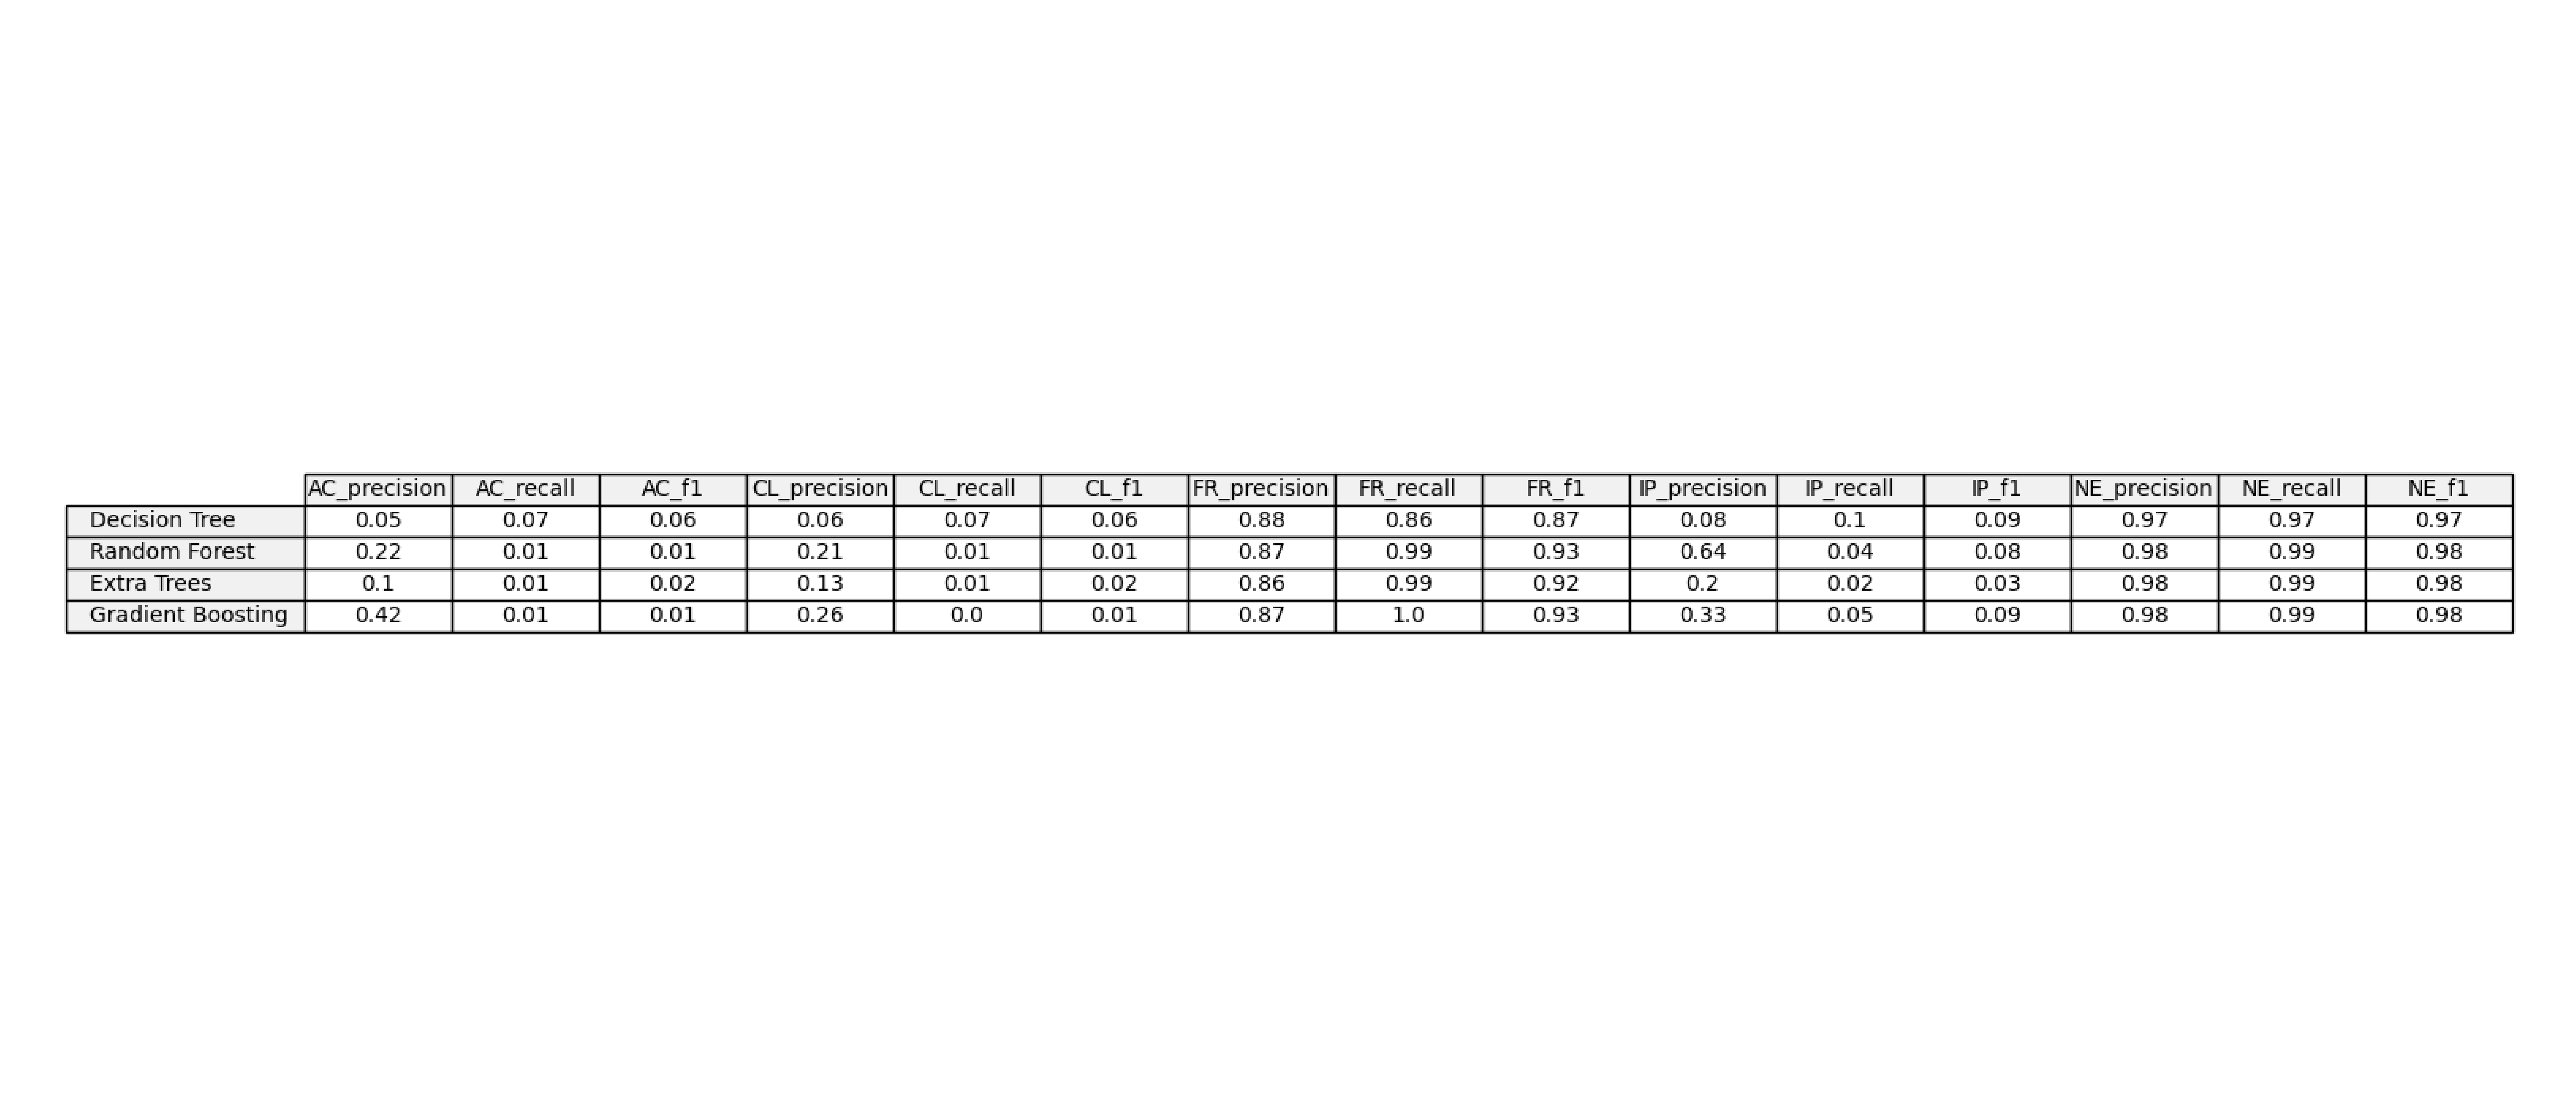

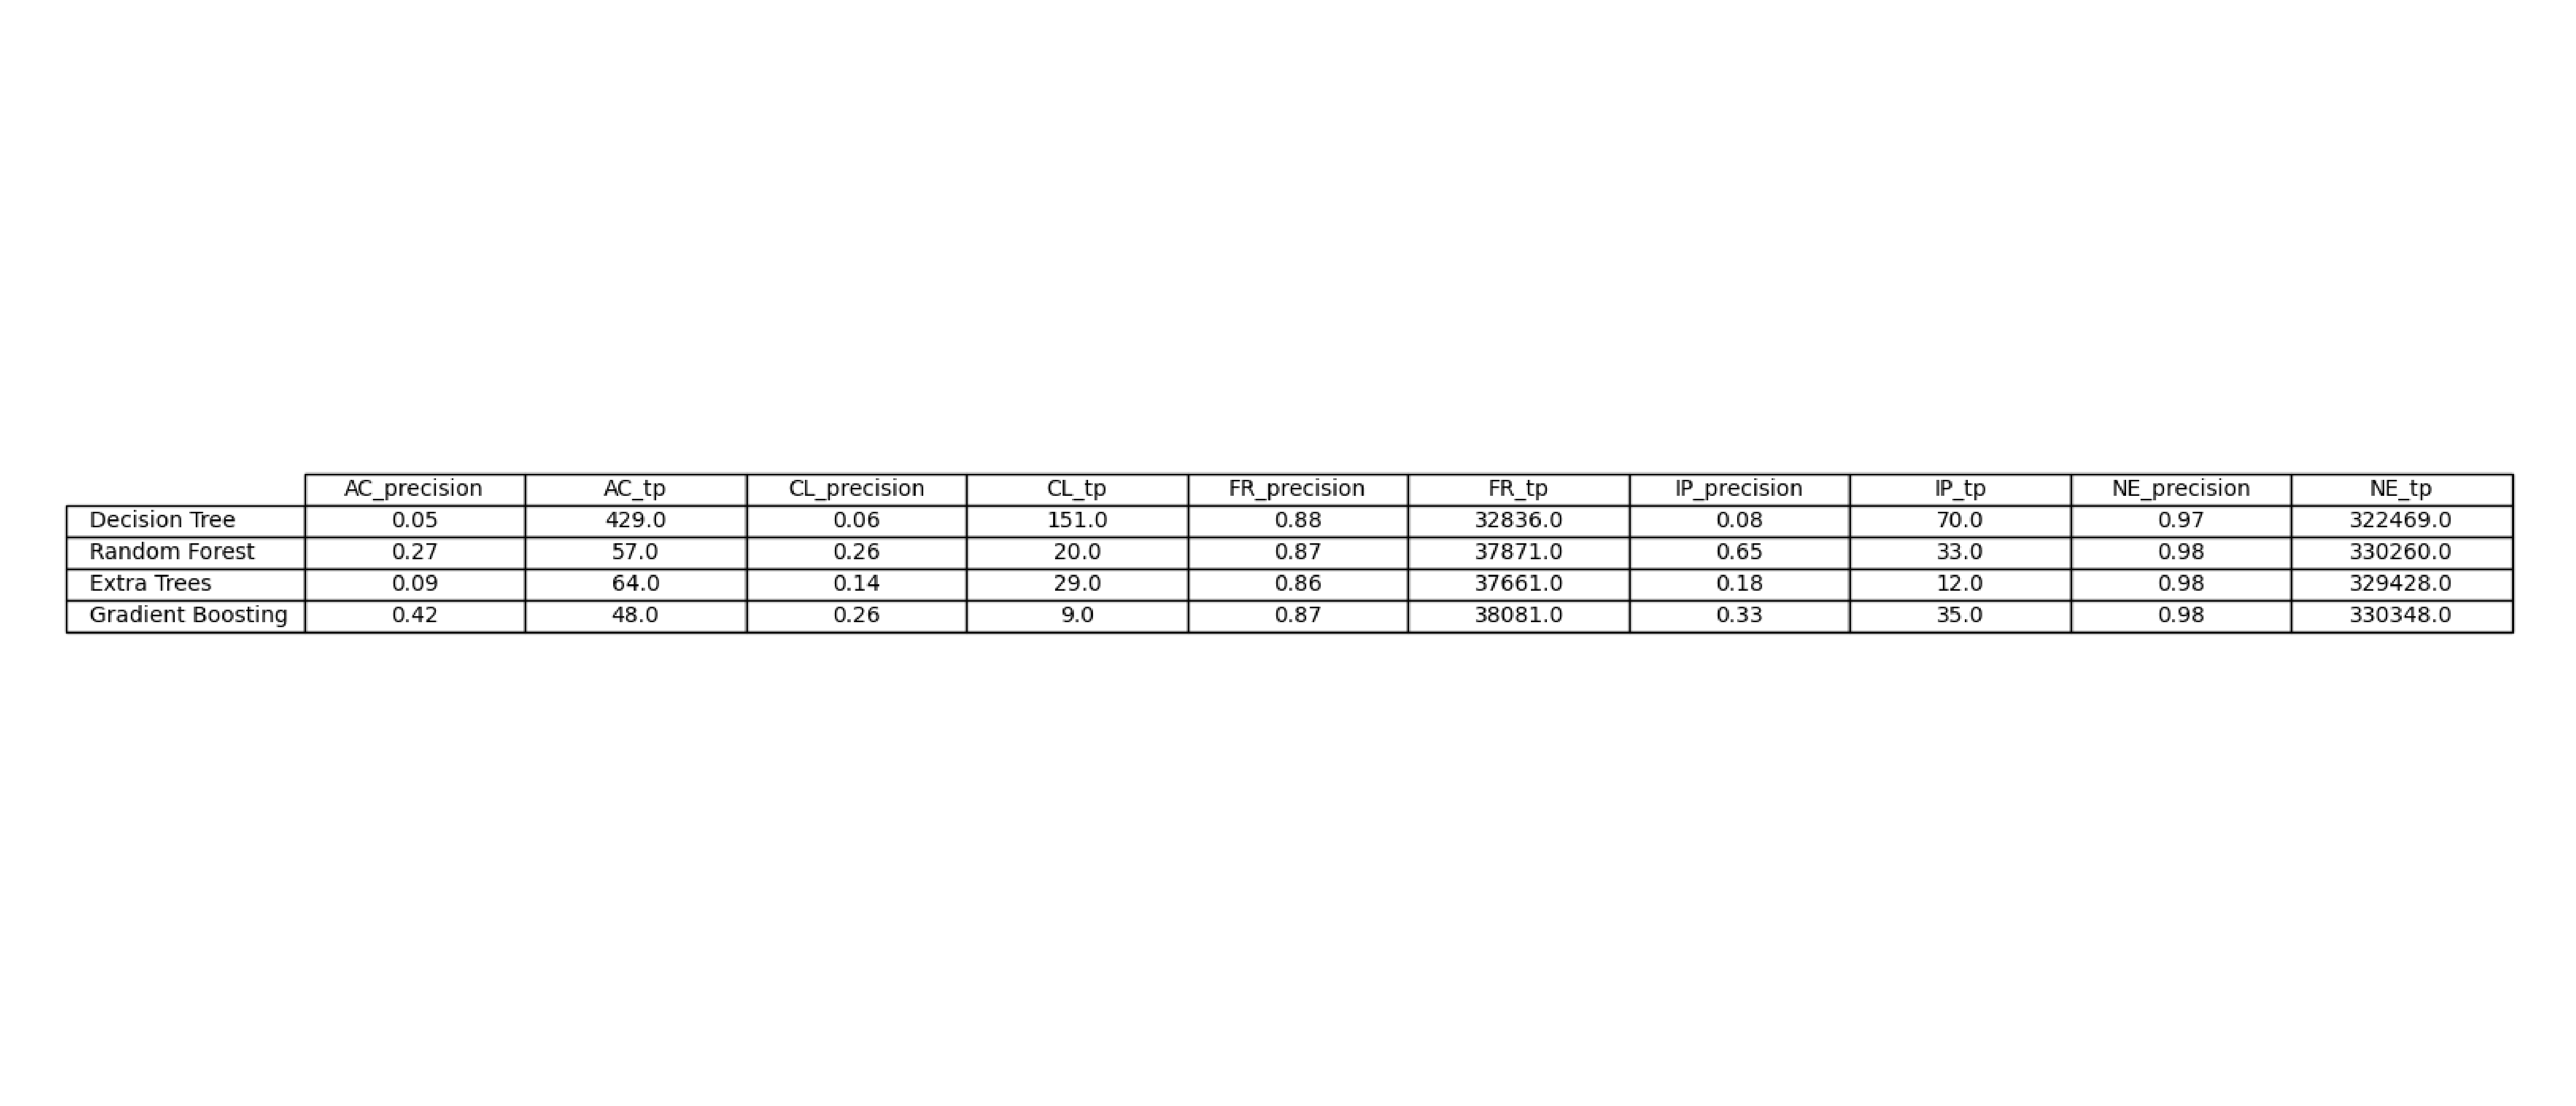

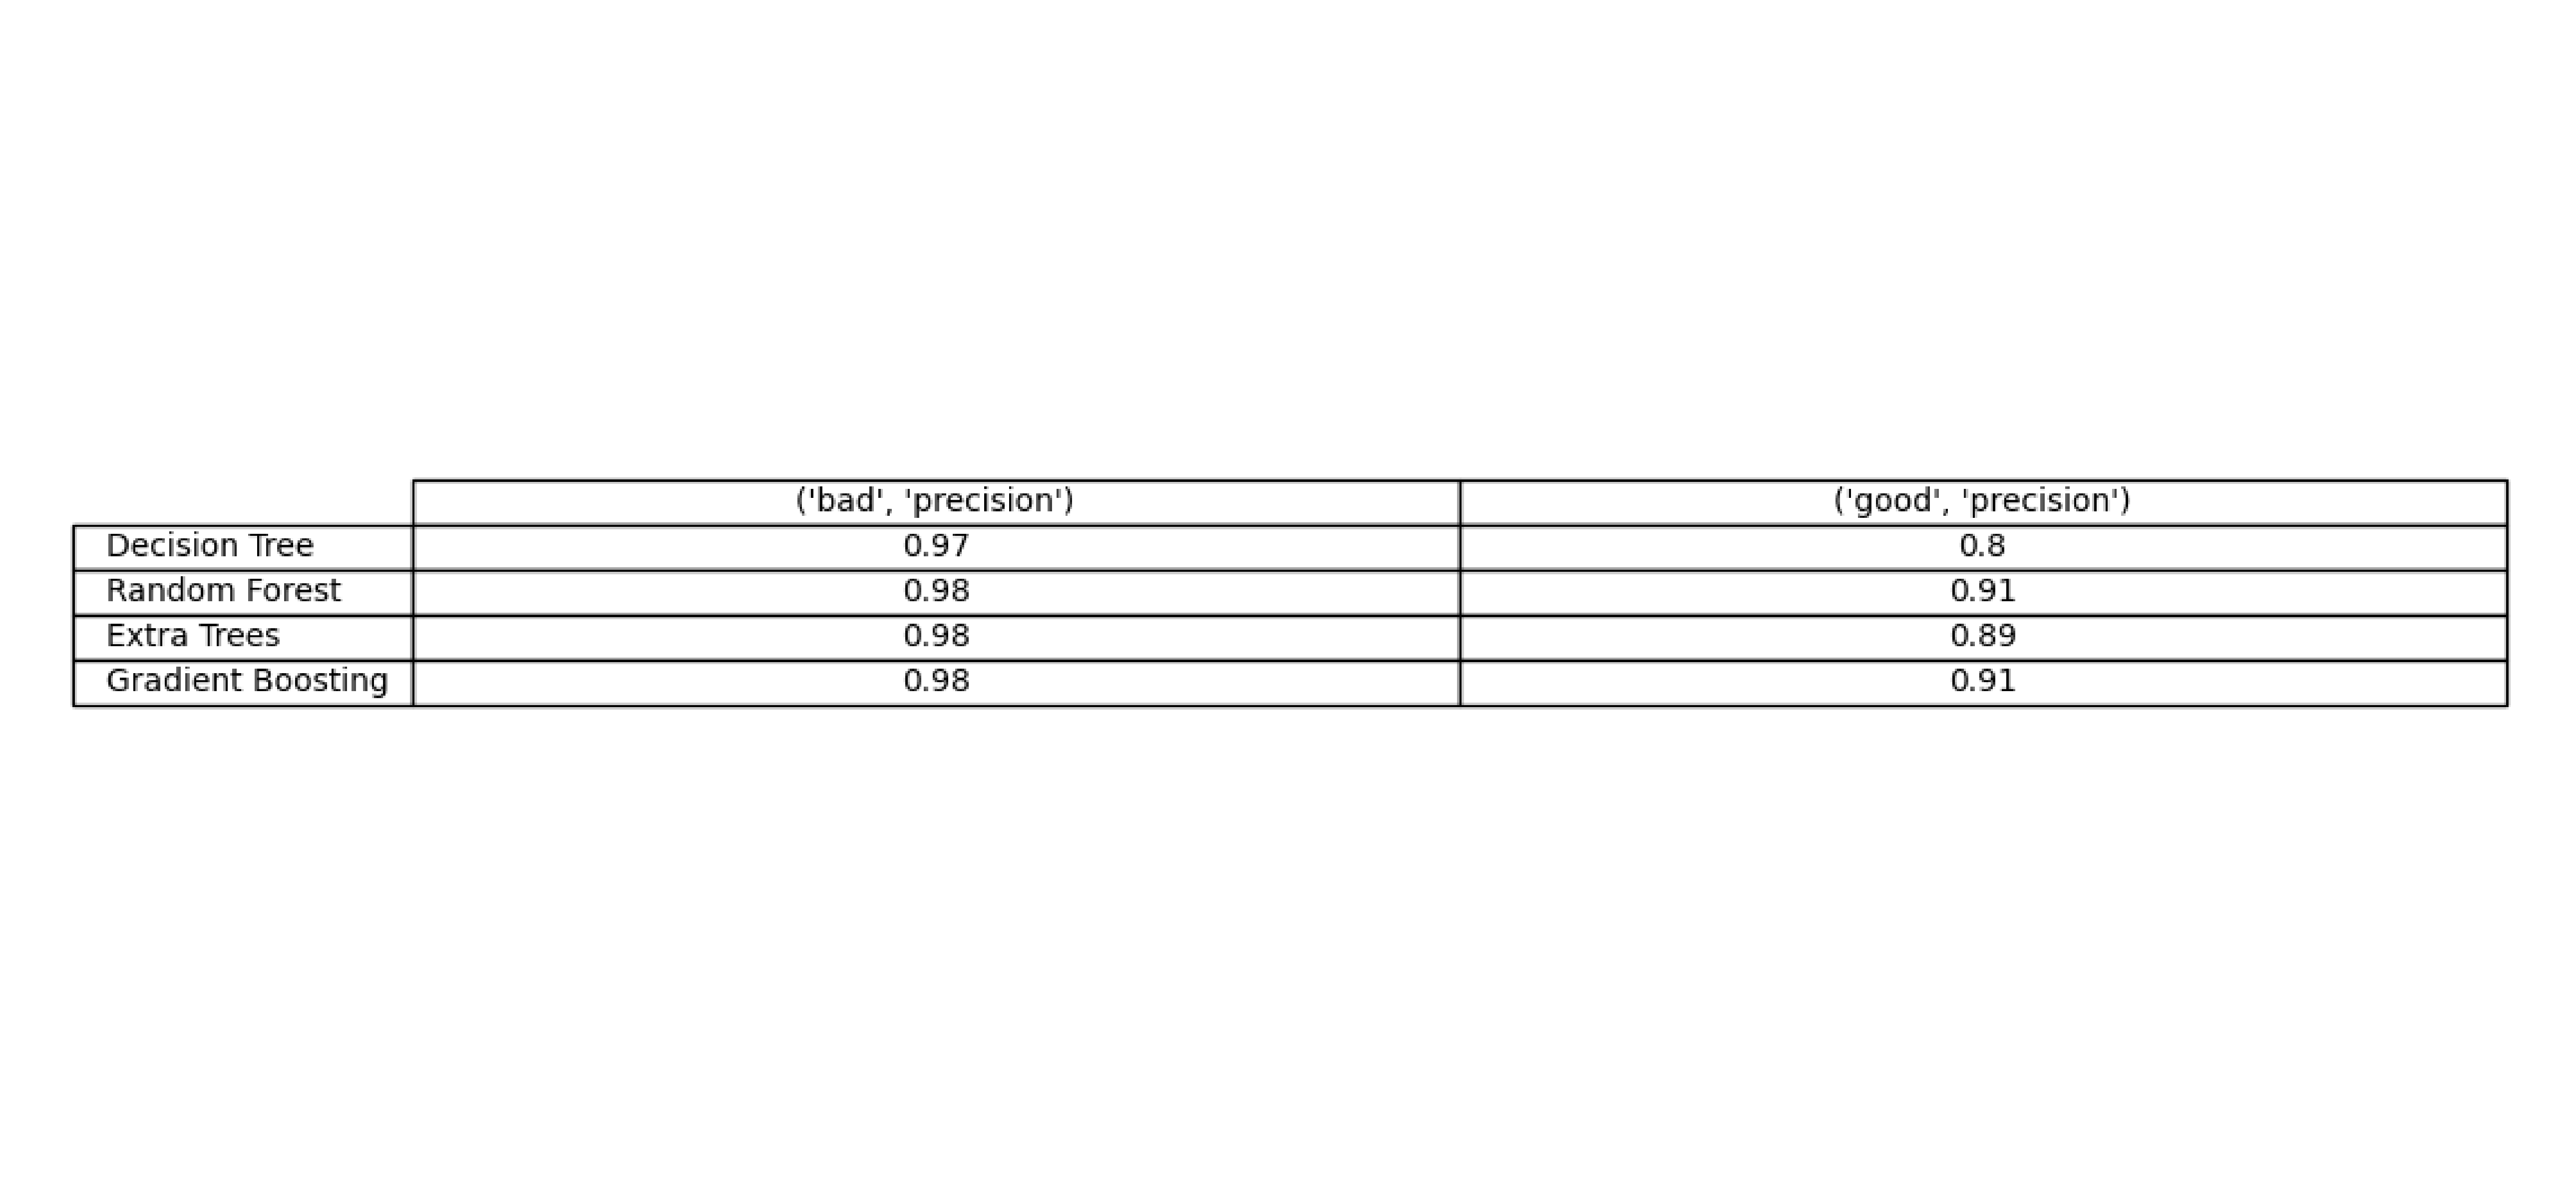

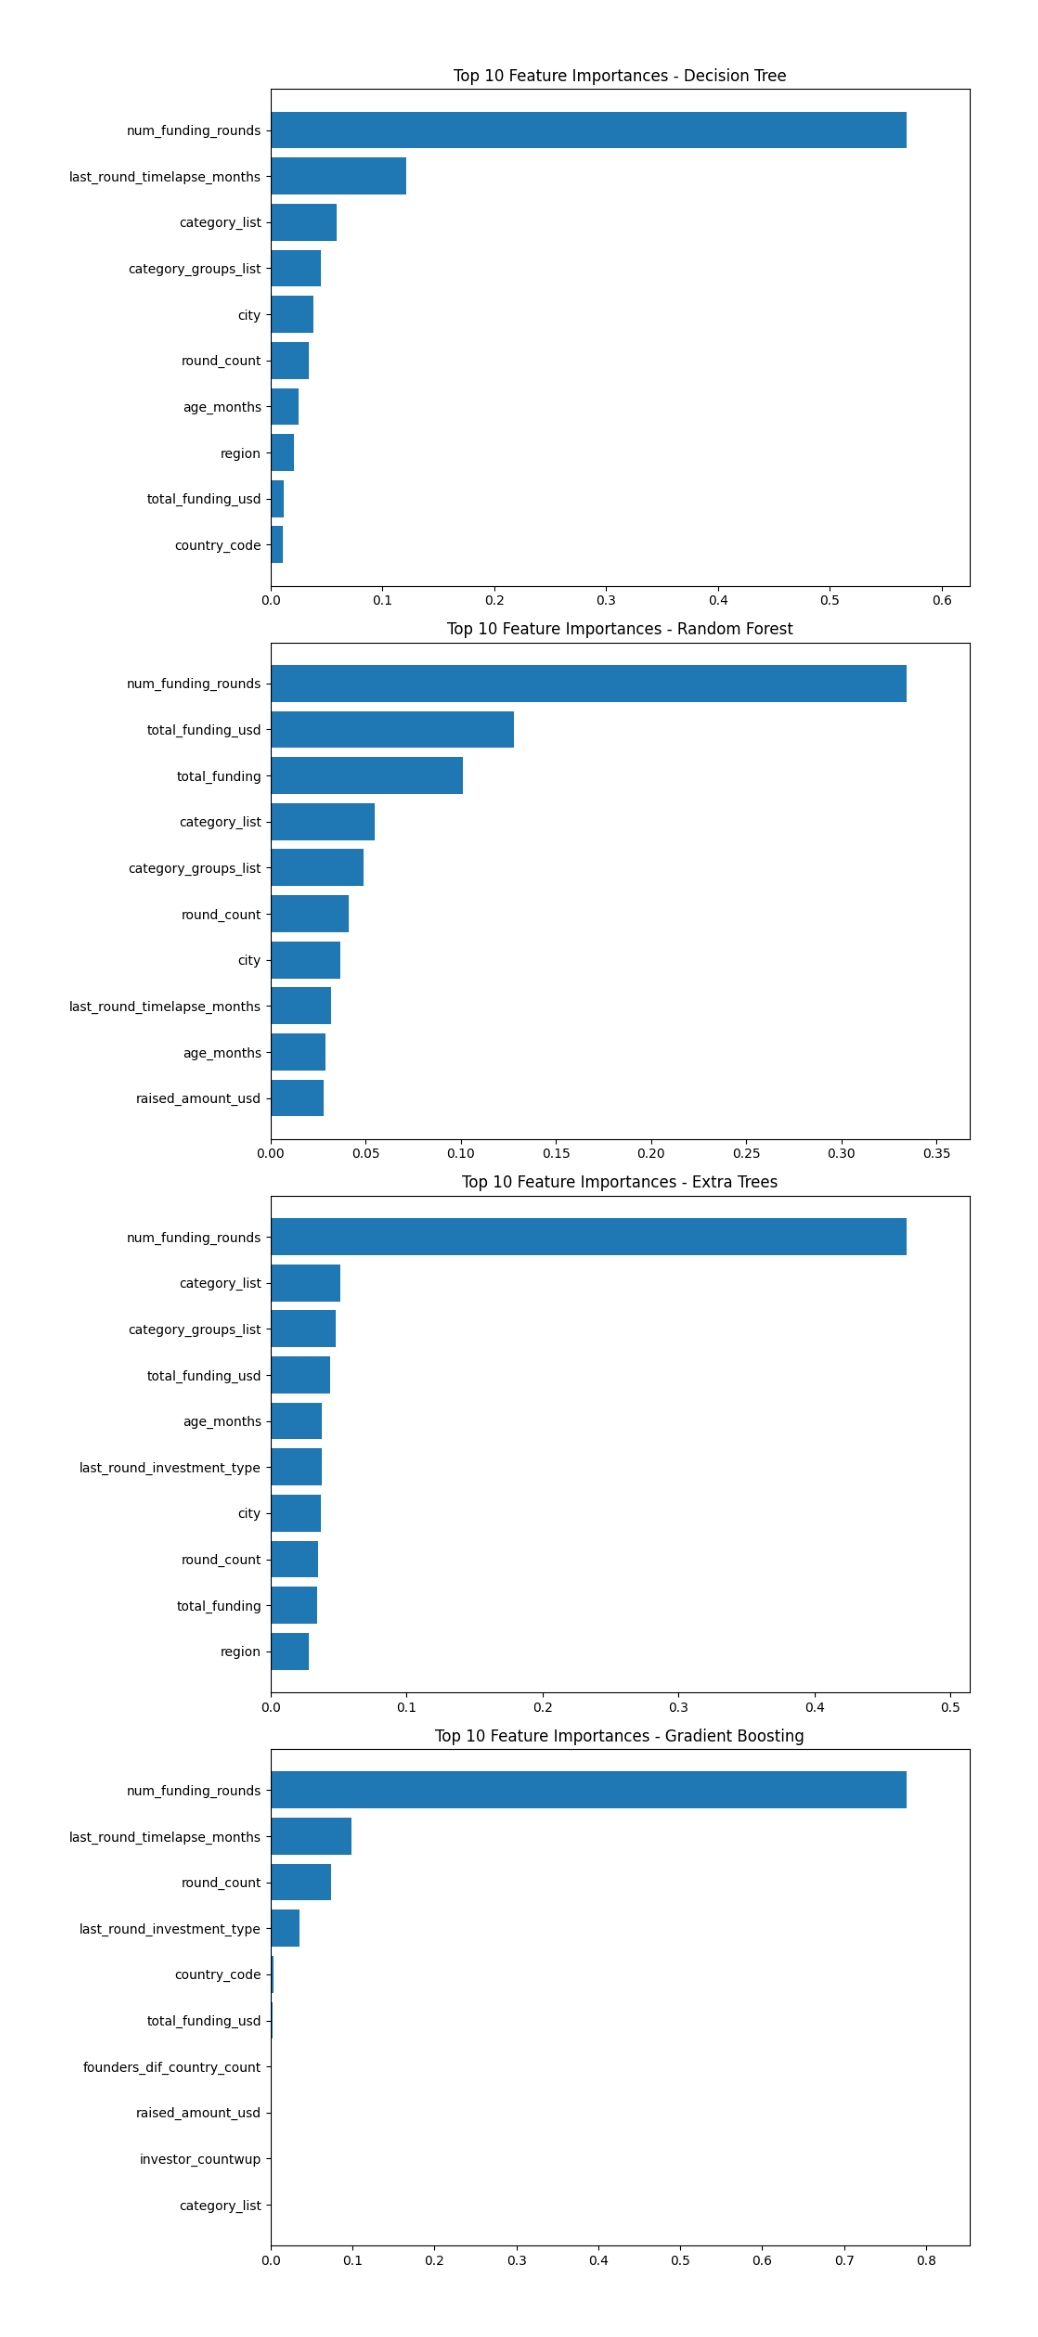

In [12]:
import pickle
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

# Load the data from the pickle file
with open('model_results_new_400k.pkl', 'rb') as file:
    data = pickle.load(file)

# Extract the dictionary and images
data_dict = data['data_dict']
image1 = data['image1']
image2 = data['image2']
image3 = data['image3']
image4 = data['image4']
image5 = data['image5']

results = data_dict['results']
outcome_distribution = data_dict['outcome_distribution']
classes = data_dict['classes']

# Print saved results
for clf_name, result in results.items():
    print(f"{clf_name}: Mean accuracy = {result['mean_accuracy']:.4f}, Std = {result['std_accuracy']:.4f}")

# Print saved outcome distribution
print("\nClass value distribution of the outcome variable:")
print("Class\tFrequency\tRatio")
for cls, stats in outcome_distribution.items():
    print(f"{cls}\t{stats['count']}\t{stats['ratio']:.2f}%")

# Function to display an image from a BytesIO object with higher quality
def display_image(image_bytes, dpi=1000):
    image_bytes.seek(0)  # Ensure the BytesIO object is at the start
    image = Image.open(image_bytes)
    plt.figure(dpi=dpi)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Display the images with higher quality
display_image(image1)
display_image(image2)
display_image(image3)
display_image(image4, 600)
display_image(image5)


## Notes about what these values mean:

- For a given class (CL/AC/NE/FR/IP): 
    - high precision means that the algorithm returned more relevant instances than irrelevant ones
    - high recall means that an algorithm returned MOST of the relevant instances
    - F1 score is the harmonic mean of precision and recall.

- Focusing on precision of profitable classes (FR, AC, IP) is important

## General notes for application usage:

- Discard companies labelled as "no event"


Processing Decision Tree...
Processing Random Forest...
Processing Extra Trees...
Processing Gradient Boosting...
Plotting top 10 feature importances for Decision Tree...
Plotting top 10 feature importances for Random Forest...
Plotting top 10 feature importances for Extra Trees...
Plotting top 10 feature importances for Gradient Boosting...


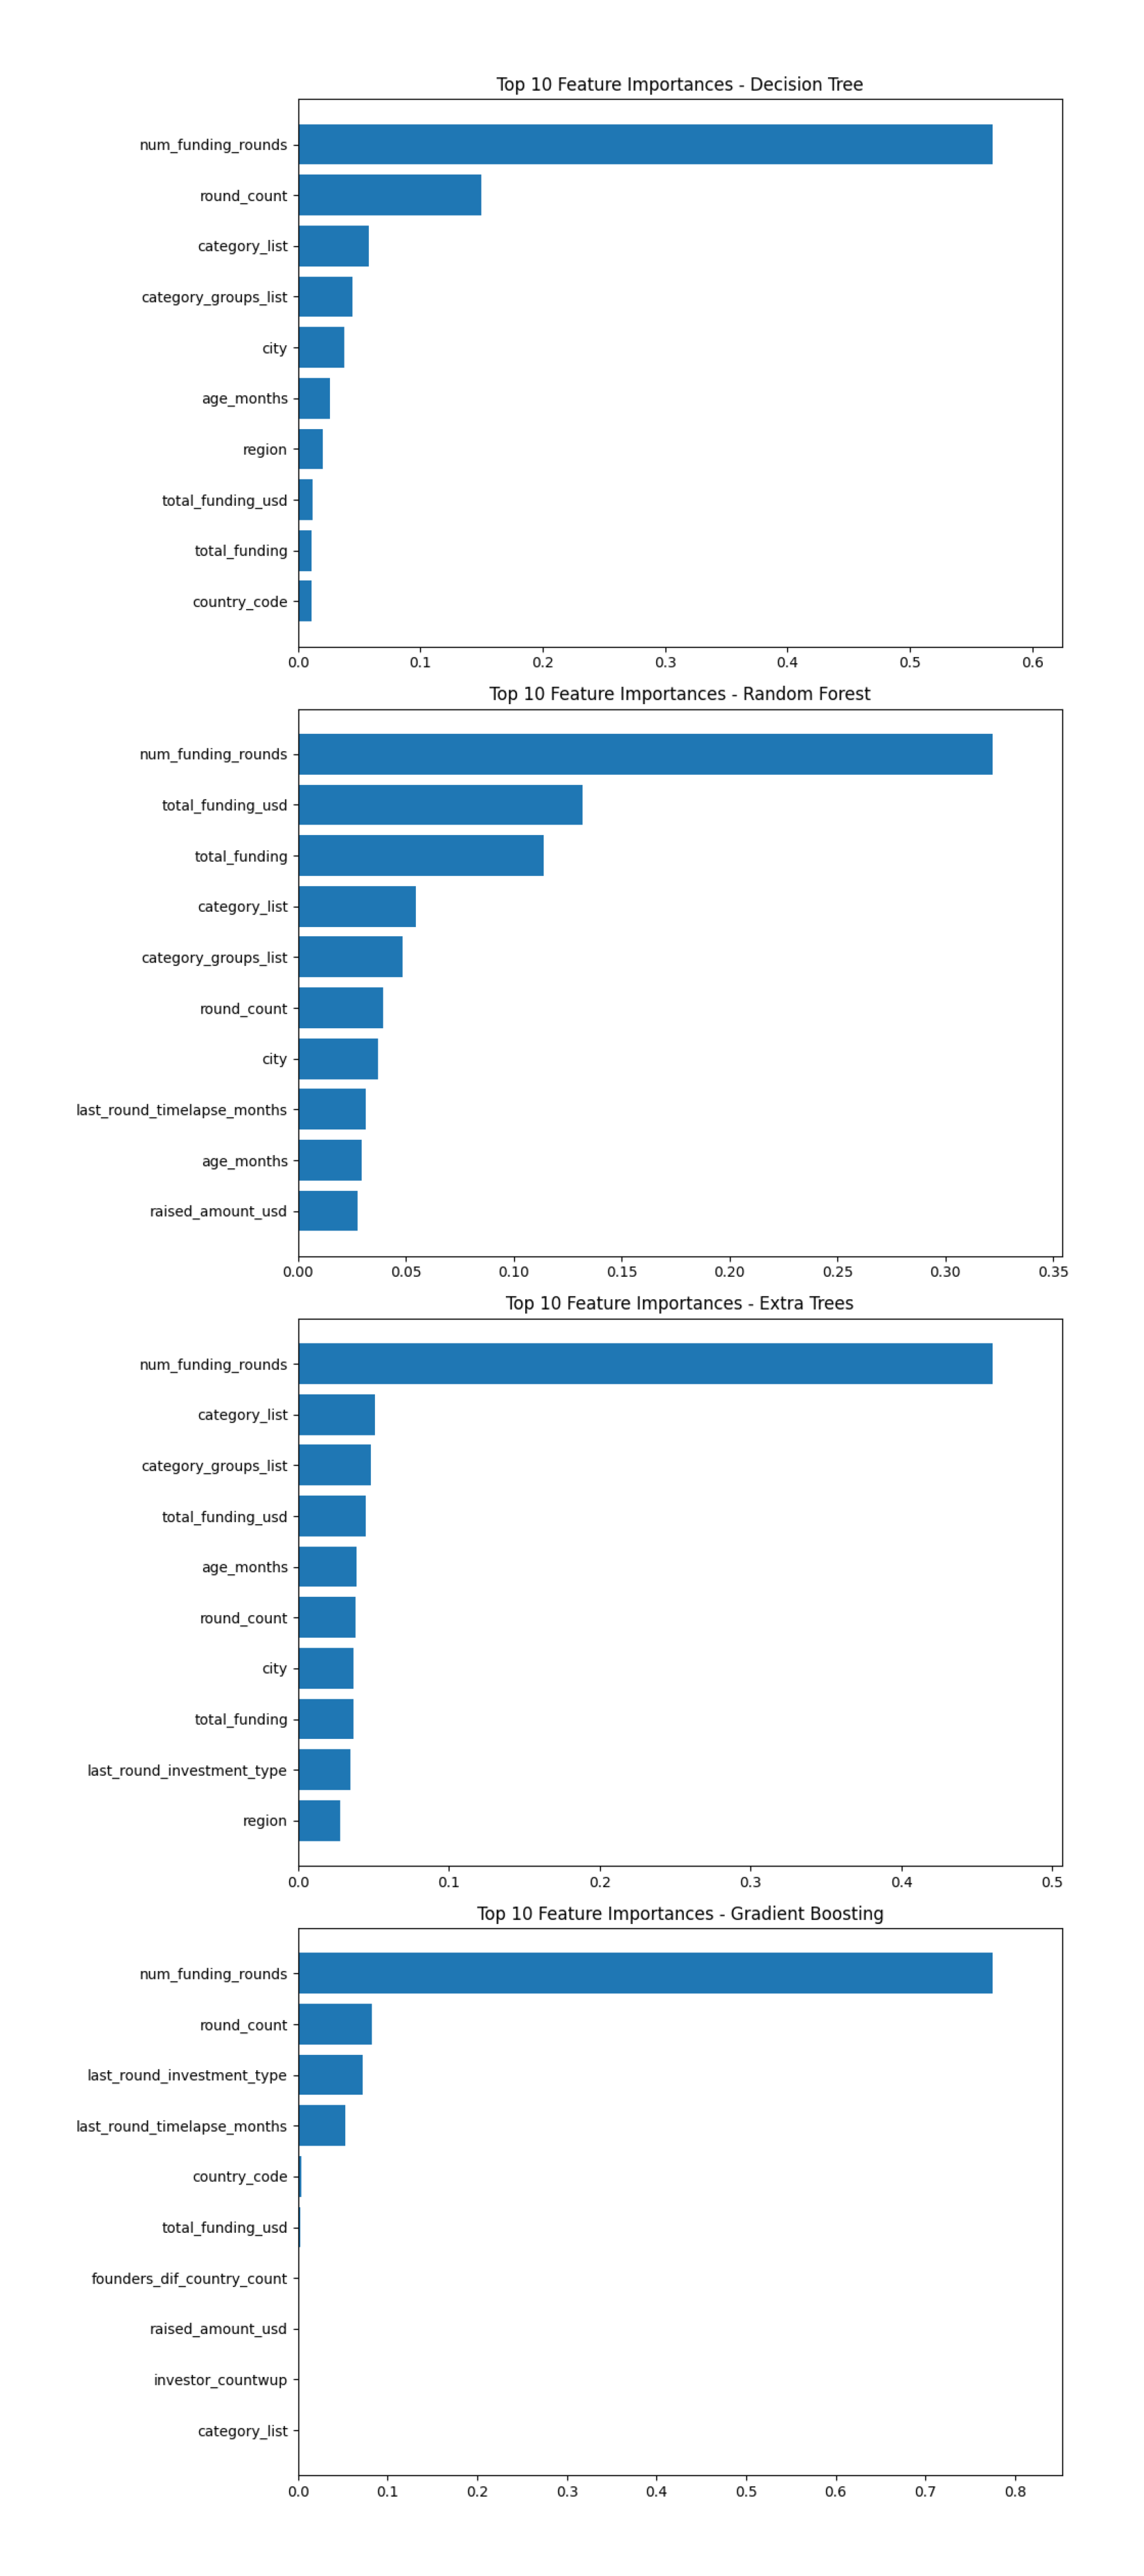

In [8]:
img = display_feature_importance_image(pd.read_csv('src/data/filtered400k.csv'))
display_image(img)